### Observed dryspells and correlation with forecasted dry spells
Process the observed dryspell list as outputed by `malawi/scripts/mwi_chirps_dry_spell_detection.R` and correlate the occurence of a dry spell with the forecasted CHIRPS-GEFS dry spell

As first analysis we are focussing on the sole occurence of a dry spell per admin2. This can be extended to e.g. duration, number of dry spells, and geographical spread

For simplicity we are only focusing on forecasting the first 15 days of a dry spell, i.e. the start date of the dry spell corresponds with the start date of the forecast   
This might be too simple, e.g. might want to forecast if a dry spell that already started will persist.

For now this means that if the start_date of the forecast occurs in the dry spell list, we classify it is a true positive

Assumptions
- We want to forecast the start of a dry spell, not if a dry spell persists
- The grid cell size is small enough to only look at cells with their centre within the region, not those touching

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterstats import zonal_stats
import rasterio
from rasterio.enums import Resampling
import matplotlib
import matplotlib.colors as mcolors
import xarray as xr
import cftime
import math
import rioxarray
from shapely.geometry import mapping
import cartopy.crs as ccrs
import matplotlib as mpl
import datetime
from datetime import timedelta
import re
import seaborn as sns
import calendar

In [3]:
from pathlib import Path
import sys
import os

path_mod = f"{Path(os.path.dirname(os.path.abspath(''))).parents[1]}/"
# print(path_mod)
sys.path.append(path_mod)
from src.indicators.drought.config import Config
from src.utils_general.utils import download_ftp,download_url
from src.utils_general.raster_manipulation import fix_calendar, invert_latlon, change_longitude_range
from src.utils_general.plotting import plot_raster_boundaries_clip,plot_spatial_columns

#### Set config values

In [4]:
country="malawi"
config=Config()
parameters = config.parameters(country)
country_dir = os.path.join(config.DIR_PATH, config.ANALYSES_DIR, country)
country_data_raw_dir = os.path.join(config.DATA_DIR,config.RAW_DIR,country)
country_data_processed_dir = os.path.join(config.DATA_DIR,config.PROCESSED_DIR,country)
country_data_exploration_dir = os.path.join(config.DATA_DIR,"exploration",country)
drought_data_exploration_dir= os.path.join(config.DATA_DIR, "exploration",  'drought')
cams_data_dir=os.path.join(drought_data_exploration_dir,"CAMS_OPI")
cams_tercile_path=os.path.join(cams_data_dir,"CAMS_tercile.nc")
chirps_monthly_dir=os.path.join(drought_data_exploration_dir,"CHIRPS")
chirps_monthly_path=os.path.join(chirps_monthly_dir,"chirps_global_monthly.nc")

chirpsgefs_dir = os.path.join(config.DROUGHTDATA_DIR,"chirps_gefs")

adm1_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin1_shp"])
adm2_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin2_shp"])

#### Load CHIRPS-GEFS data

In [45]:
hist_path=os.path.join(country_data_exploration_dir,"chirpsgefs","mwi_chirpsgefs_rainyseas_stats_mean_back.csv")
df_chirpsgefs=pd.read_csv(hist_path)
df_chirpsgefs["date"]=pd.to_datetime(df_chirpsgefs["date"])#.dt.to_period("d")
df_chirpsgefs["date_forec_end"]=pd.to_datetime(df_chirpsgefs["date_forec_end"])#.dt.to_period("d")

In [46]:
# #05-03-2021: chirpsgefs data before 2010 isn't yet complete--> focus on data from 2010 for now to circumvent biases
# 15-03-2021: data is complete now
# df_chirpsgefs=df_chirpsgefs[df_chirpsgefs.date.dt.year>=2010]

In [47]:
# 15-03-2021: due to update of system, no data is available from 01-01-2020 till 05-10-2021
# one of the versions, did include this data from another model version but according to CHCH this is not valid to use, so remove
df_chirpsgefs=df_chirpsgefs[(df_chirpsgefs.date<="01-01-2020")|(df_chirpsgefs.date>="05-10-2020")]

In [48]:
#most dates are already removed in prepocessing notebook, but since dfeinition of rainy season changed, recomputing them

In [49]:
# #path to data start and end rainy season
# df_rain=pd.read_csv(os.path.join(country_data_processed_dir,"dry_spells","rainy_seasons_detail_2000_2020_mean_back.csv"))
# df_rain["onset_date"]=pd.to_datetime(df_rain["onset_date"])#.dt.to_period('d')
# df_rain["cessation_date"]=pd.to_datetime(df_rain["cessation_date"])#.dt.to_period('d')

In [50]:
# #set the onset and cessation date for the seasons where these are missing 
# #(meaning there was no dry spell data from start/till end of the season)
# df_rain_filled=df_rain.copy()
# df_rain_filled=df_rain_filled[(df_rain_filled.onset_date.notnull())|(df_rain_filled.cessation_date.notnull())]
# df_rain_filled[df_rain_filled.onset_date.isnull()]=df_rain_filled[df_rain_filled.onset_date.isnull()].assign(onset_date=lambda df: pd.to_datetime(f"{df.season_approx.values[0]}-11-01"))
# df_rain_filled[df_rain_filled.cessation_date.isnull()]=df_rain_filled[df_rain_filled.cessation_date.isnull()].assign(cessation_date=lambda df: pd.to_datetime(f"{df.season_approx.values[0]+1}-07-01"))

In [51]:
# #remove the adm2-date entries outside the rainy season for that specific adm2
# #df_belowavg_seas only includes data from 2000, so the 1999 entries are not included
# list_hist_rain_adm2=[]
# for a in df_rain_filled.ADM2_EN.unique():
#     dates_adm2=pd.Index([])
#     for i in df_rain_filled[df_rain_filled.ADM2_EN==a].season_approx.unique():
#         df_rain_adm2_seas=df_rain_filled[(df_rain_filled.ADM2_EN==a)&(df_rain_filled.season_approx==i)]
#         seas_range=pd.period_range(df_rain_adm2_seas.onset_date.values[0],df_rain_adm2_seas.cessation_date.values[0],freq="D")
#         dates_adm2=dates_adm2.union(seas_range)
#     list_hist_rain_adm2.append(df_chirpsgefs[(df_chirpsgefs.ADM2_EN==a)&(df_chirpsgefs.date.isin(dates_adm2))])
# df_chirpsgefs=pd.concat(list_hist_rain_adm2)
# df_chirpsgefs.date=pd.to_datetime(df_chirpsgefs.date.astype(str))#, format='%Y-%m-%d')
# df_chirpsgefs.date_forec_end=pd.to_datetime(df_chirpsgefs.date_forec_end.astype(str))

In [52]:
cg_stats=["max_cell","mean_cell","min_cell","perc_se2","perc_se10"]

In [53]:
len(df_chirpsgefs)

77184

In [54]:
len(df_chirpsgefs.date.unique())

3358

In [55]:
df_chirpsgefs.date.dt.month.unique()

array([ 1,  2,  3, 11, 12,  4,  5])

In [56]:
len(df_chirpsgefs.ADM2_EN.unique())

32

In [57]:
df_chirpsgefs

,Shape_Leng,Shape_Area,ADM2_EN,ADM2_PCODE,ADM2_REF,ADM2ALT1EN,ADM2ALT2EN,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,max_cell,min_cell,mean_cell,perc_se2,perc_se10,date_forec_end
0,2.036817,0.179379,Balaka,MW312,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2000-01-01,2018-10-16,NaN,98.036362,62.076710,80.531206,0.0,0.0,2000-01-15
1,2.036817,0.179379,Balaka,MW312,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2000-01-02,2018-10-16,NaN,162.112625,102.041756,129.338437,0.0,0.0,2000-01-16
2,2.036817,0.179379,Balaka,MW312,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2000-01-03,2018-10-16,NaN,136.109085,78.451447,111.754927,0.0,0.0,2000-01-17
3,2.036817,0.179379,Balaka,MW312,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2000-01-04,2018-10-16,NaN,142.170609,89.597649,119.948888,0.0,0.0,2000-01-18
4,2.036817,0.179379,Balaka,MW312,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2000-01-05,2018-10-16,NaN,111.420197,83.012993,98.433085,0.0,0.0,2000-01-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77179,0.295003,0.003375,Zomba City,MW314,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2021-03-08,2018-10-16,NaN,174.211685,174.211685,174.211685,0.0,0.0,2021-03-22
77180,0.295003,0.003375,Zomba City,MW314,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2021-03-09,2018-10-16,NaN,156.969940,156.969940,156.969940,0.0,0.0,2021-03-23
77181,0.295003,0.003375,Zomba City,MW314,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2021-03-10,2018-10-16,NaN,143.903870,143.903870,143.903870,0.0,0.0,2021-03-24
77182,0.295003,0.003375,Zomba City,MW314,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2021-03-11,2018-10-16,NaN,175.718323,175.718323,175.718323,0.0,0.0,2021-03-25


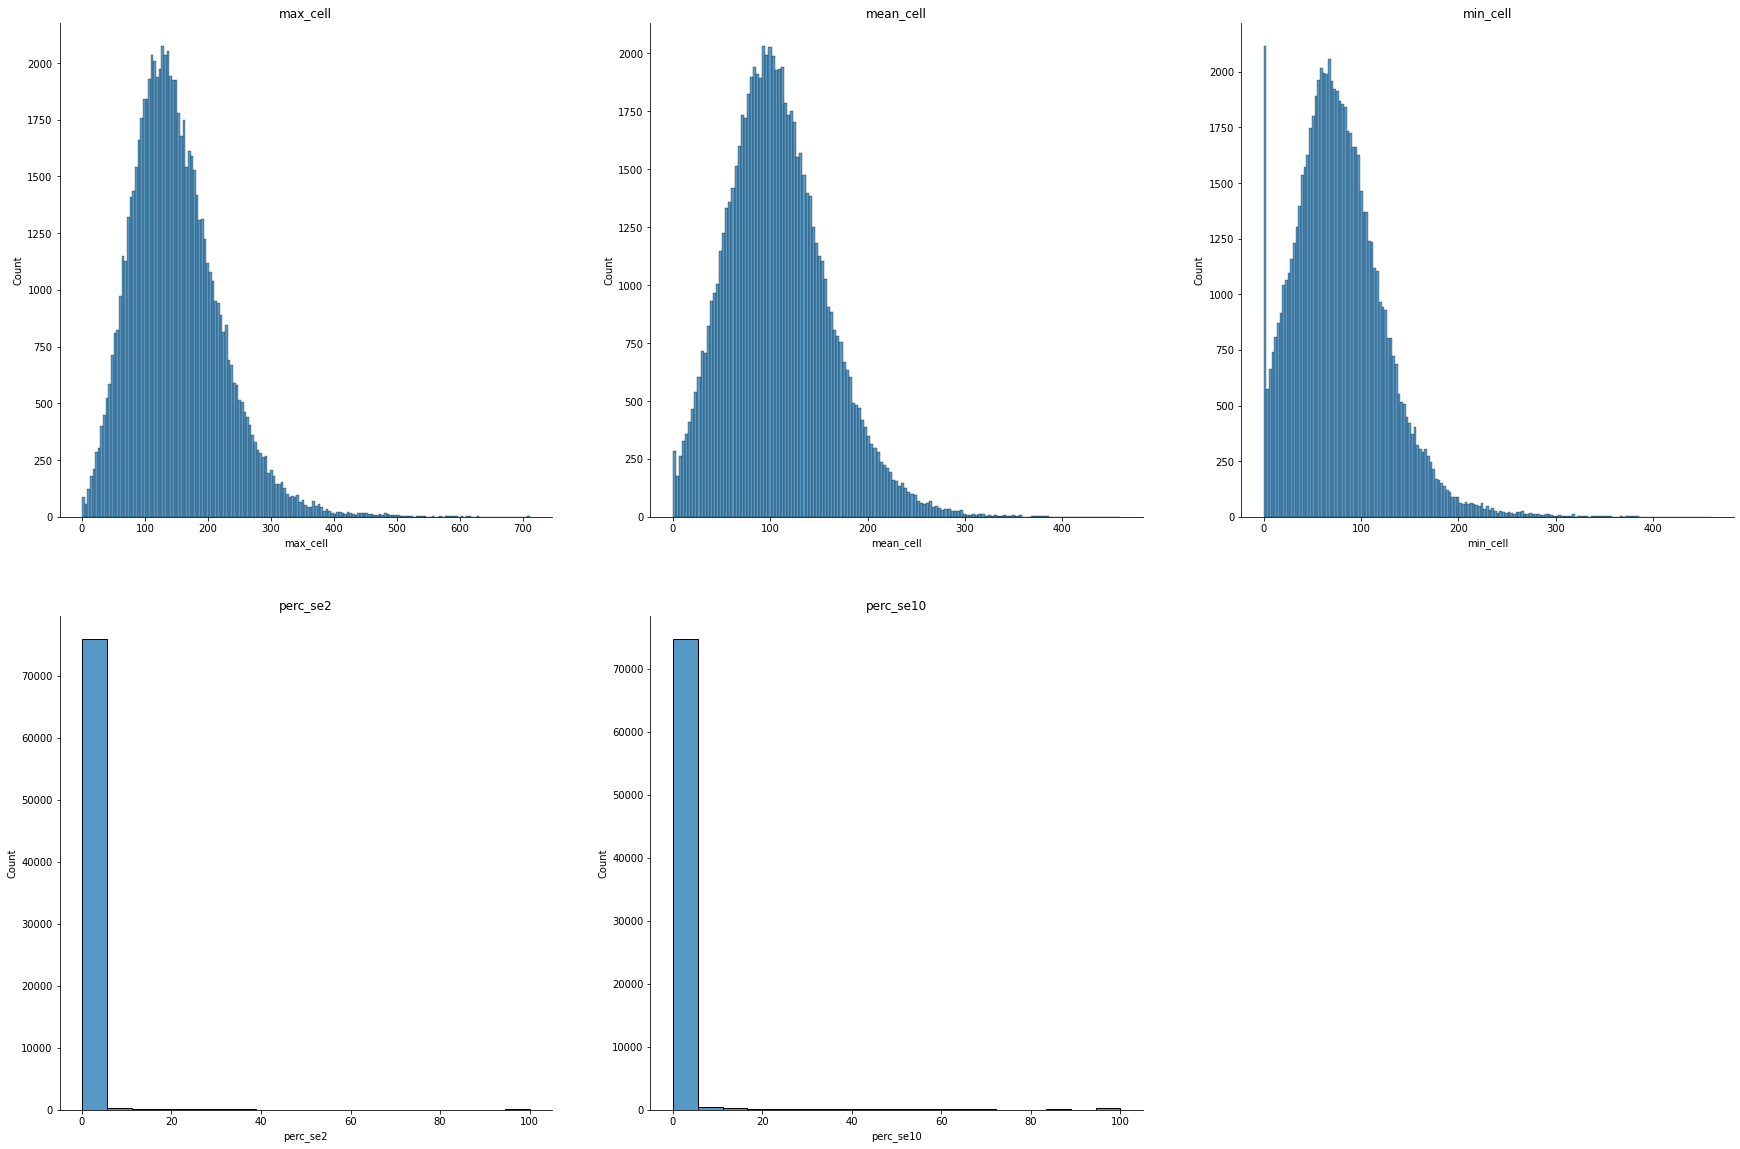

In [58]:
num_plots = len(cg_stats)
colp_num=3
if num_plots==1:
    colp_num=1
rows = math.ceil(num_plots / colp_num)
position = range(1, num_plots + 1)
fig=plt.figure(figsize=(30,20))
for i, s in enumerate(cg_stats):
    ax = fig.add_subplot(rows,colp_num,i+1)
    sns.histplot(df_chirpsgefs,x=s,ax=ax)
    ax.set_title(s)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [59]:
# print("number of adm2-date combination with max cell <=2mm:",len(df_chirpsgefs[df_chirpsgefs.max_cell<=2]))
# print("number of dates with at least one adm2 with max cell <=2mm:",len(df_chirpsgefs[df_chirpsgefs.max_cell<=2].date.unique()))
# print("number of adm2-date combination with mean cell <=2mm:",len(df_chirpsgefs[df_chirpsgefs.mean_cell<=2]))
# print("number of dates with at least one adm2 with mean cell <=2mm:",len(df_chirpsgefs[df_chirpsgefs.mean_cell<=2].date.unique()))

#### Load observed dry spells

In [60]:
#different methodologies of computing the observed dry spells 
#set the one being used, dryspell_obs_suffix determines which file to load
dryspell_obs_stat="mean" #"max"
if dryspell_obs_stat=="max":
    dryspell_obs_suffix=""
else:
    dryspell_obs_suffix=f"_{dryspell_obs_stat}"


df_ds=pd.read_csv(os.path.join(country_data_processed_dir,"dry_spells",f"dry_spells_during_rainy_season_list_2000_2020{dryspell_obs_suffix}_back.csv"))
df_ds["dry_spell_first_date"]=pd.to_datetime(df_ds["dry_spell_first_date"])
df_ds["dry_spell_last_date"]=pd.to_datetime(df_ds["dry_spell_last_date"])
df_ds["year"]=df_ds.dry_spell_first_date.dt.year

In [61]:
df_ds

,pcode,ADM2_EN,season_approx,dry_spell_first_date,dry_spell_last_date,dry_spell_duration,dry_spell_rainfall,region,year
0,MW203,Ntchisi,2004,2005-03-08,2005-03-26,19,1.2,Central,2005
1,MW205,Salima,2004,2005-03-02,2005-03-26,25,1.6,Central,2005
2,MW209,Ntcheu,2004,2005-03-02,2005-03-25,24,1.7,Central,2005
3,MW302,Machinga,2004,2005-01-31,2005-02-13,14,1.0,Southern,2005
4,MW304,Chiradzulu,2007,2008-02-10,2008-02-24,15,0.0,Southern,2008
5,MW304,Chiradzulu,2009,2010-01-01,2010-01-14,14,1.0,Southern,2010
6,MW304,Chiradzulu,2019,2020-02-26,2020-03-10,14,0.3,Southern,2020
7,MW305,Blantyre,2007,2008-02-10,2008-02-24,15,0.1,Southern,2008
8,MW305,Blantyre,2009,2010-01-01,2010-01-14,14,1.7,Southern,2010
9,MW305,Blantyre,2019,2020-02-26,2020-03-10,14,1.7,Southern,2020


In [62]:
df_ds["dry_spell_extension"]=df_ds.dry_spell_duration-14
print(df_ds.dry_spell_extension.sum())

74


<AxesSubplot:xlabel='dry_spell_duration', ylabel='Count'>

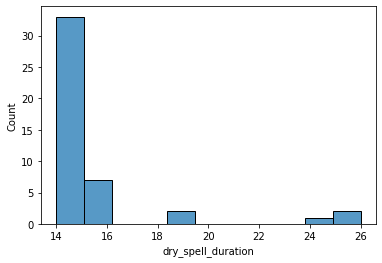

In [63]:
sns.histplot(df_ds,x="dry_spell_duration")

In [64]:
#number of historically observed dry spells
#this is waay less than the predicted..
len(df_ds)

45

In [65]:
len(df_ds[df_ds.dry_spell_first_date.dt.year>=2010])

23

In [66]:
#chirpsgefs 2020 data is not complete, so these might be removed
len(df_ds[df_ds.dry_spell_first_date.dt.year==2020])

6

In [67]:
from src.utils_general.plotting import plot_raster_boundaries_clip,plot_spatial_columns

<Figure size 432x288 with 0 Axes>

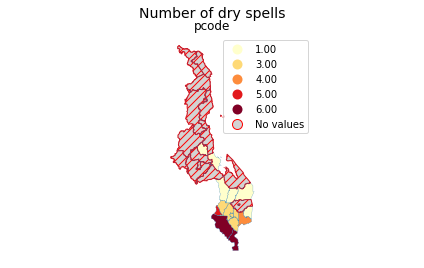

In [68]:
df_ds_adm2=df_ds.groupby(["ADM2_EN"],as_index=False).count()
df_bound_adm2=gpd.read_file(adm2_bound_path)
gdf_ds_adm2=df_bound_adm2.merge(df_ds_adm2,how="left")#.merge(df_bound_adm2)
# df_bound_adm2.boundary.plot()
fig=plot_spatial_columns(gdf_ds_adm2, ["pcode"], title="Number of dry spells", predef_bins=None,cmap='YlOrRd',colp_num=1)


In [69]:
df_ds_adm2

,ADM2_EN,pcode,season_approx,dry_spell_first_date,dry_spell_last_date,dry_spell_duration,dry_spell_rainfall,region,year,dry_spell_extension
0,Balaka,1,1,1,1,1,1,1,1,1
1,Blantyre,3,3,3,3,3,3,3,3,3
2,Blantyre City,3,3,3,3,3,3,3,3,3
3,Chikwawa,6,6,6,6,6,6,6,6,6
4,Chiradzulu,3,3,3,3,3,3,3,3,3
5,Machinga,1,1,1,1,1,1,1,1,1
6,Mulanje,4,4,4,4,4,4,4,4,4
7,Mwanza,5,5,5,5,5,5,5,5,5
8,Neno,3,3,3,3,3,3,3,3,3
9,Nsanje,6,6,6,6,6,6,6,6,6


Text(0, 0.5, 'Number of dry spells')

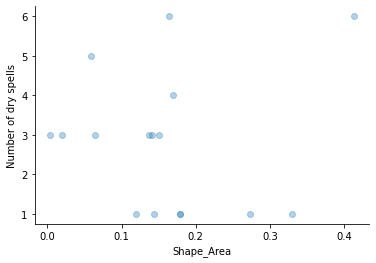

In [70]:
#check correlation with size of area and number of dry spells
g=sns.regplot(data=gdf_ds_adm2,y="pcode",x="Shape_Area",scatter_kws = {'alpha' : 1/3},fit_reg=False)
ax=g.axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("Number of dry spells")

In [71]:
#compute years with a dry spell compared to total number of dry spells per admin2
# df_ds_adm2_year=df_ds.drop_duplicates(["year","ADM2_EN"]).groupby("ADM2_EN",as_index=False).count()
# gdf_ds_adm2_year=df_bound_adm2.merge(df_ds_adm2_year)
# fig=plot_spatial_columns(gdf_ds_adm2_year, ["pcode"], title="Number of dry spells", predef_bins=None,cmap='YlOrRd',colp_num=1)

### Observed dryspells and correlation with forecasted dry spells

In [86]:
#combine chirpsgefs and observed dryspells data
#merge on right to include all adm2-dates present in chirpsgefs
#df_chirpsgefs, only includes the dates per adm2 that were in a rainy season
df_comb=df_ds.merge(df_chirpsgefs[["ADM2_EN","date","date_forec_end"]+cg_stats],how="right",left_on=["dry_spell_first_date","ADM2_EN"],right_on=["date","ADM2_EN"])

In [87]:
#nan = there was a forecast but no observed dry spell--> set occurence of dry spell to zero
#again, only looking at if any dry spell started on that date, not whether it persisted
df_comb["dryspell_obs"]=np.where(df_comb.dry_spell_first_date.notna(),1,0)

In [88]:
len(df_ds)

45

In [89]:
# Aaah somehow dry spells went missing when merging on the forecast list
#reason data from 2020 is missing...
len(df_comb[df_comb.dryspell_obs==1])

39

In [90]:
#THIS IS NOT  A CORRECT WAY OF DOING IT
#since only  looking at start of a dry spell, while a forecast can also continue forecasting a dry spell while the dry spell has alrady started..

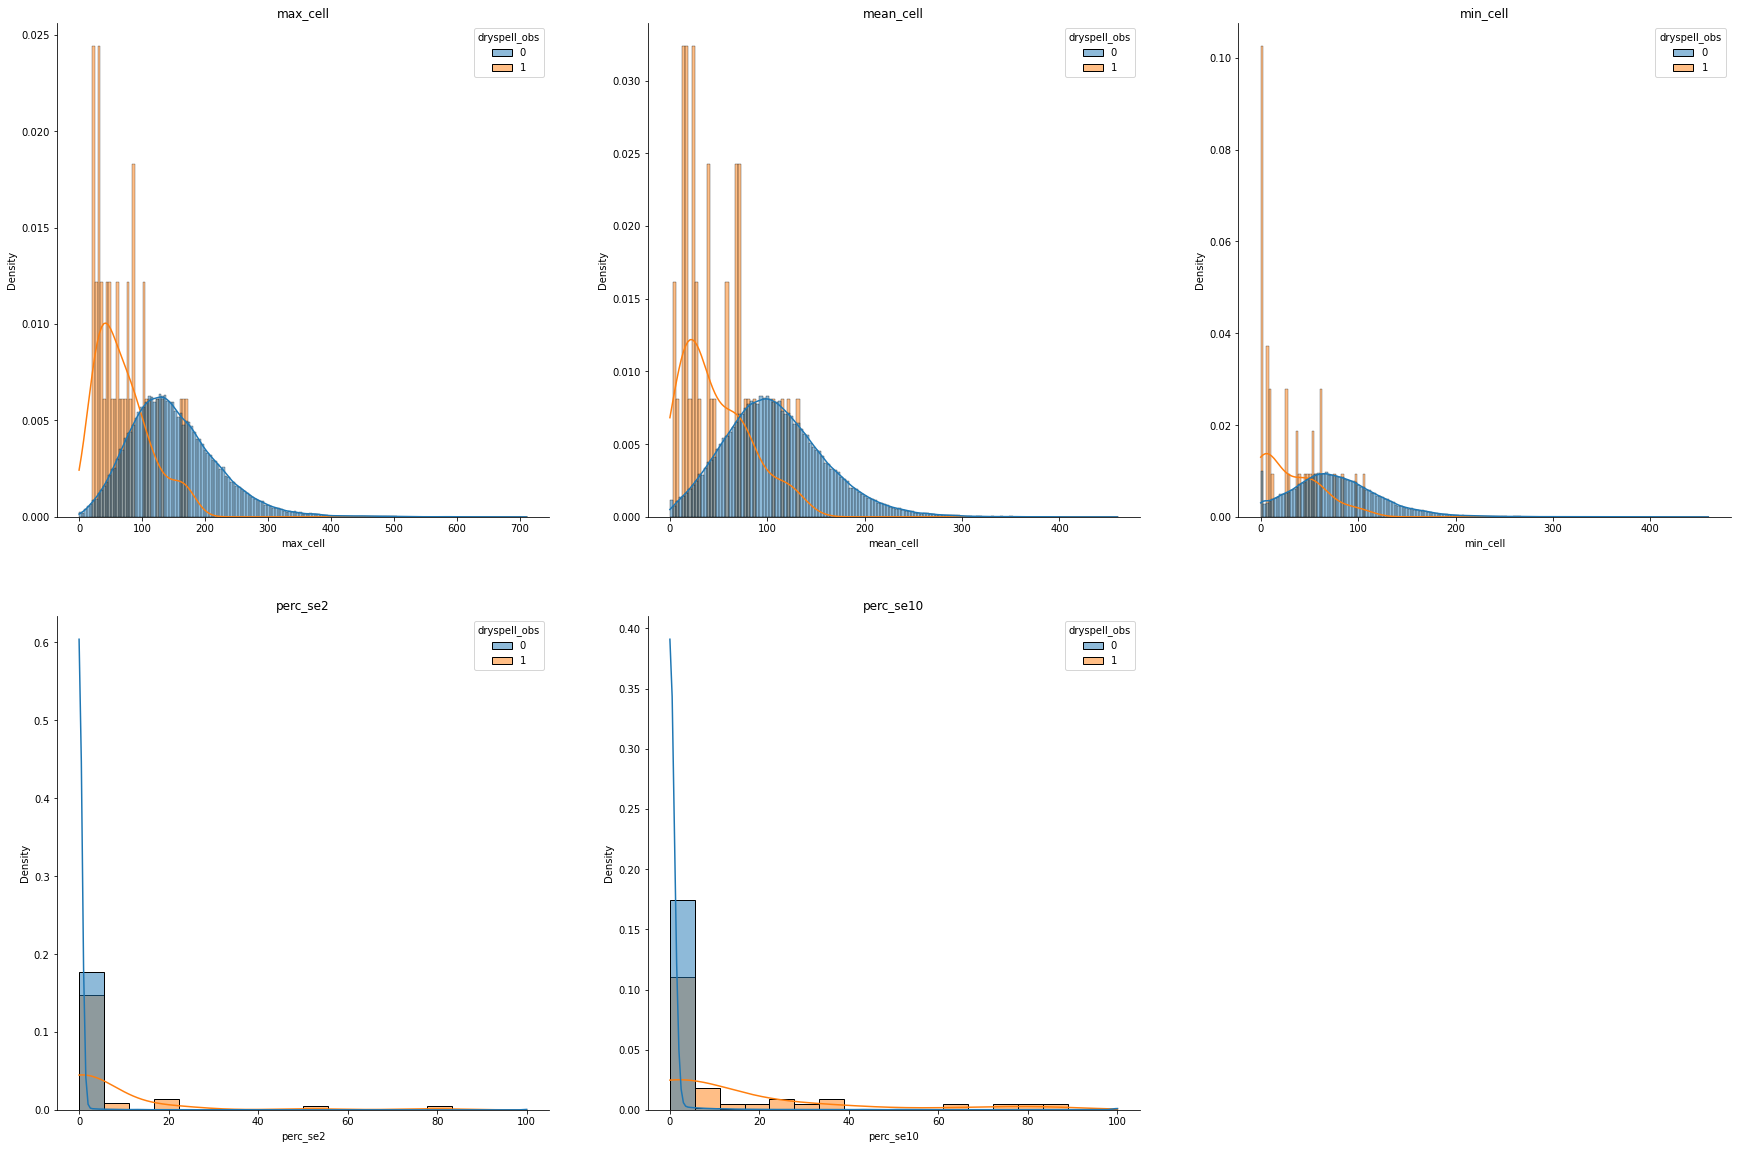

In [91]:
num_plots = len(cg_stats)
colp_num=3
if num_plots==1:
    colp_num=1
rows = math.ceil(num_plots / colp_num)
position = range(1, num_plots + 1)
fig=plt.figure(figsize=(30,20))
for i, s in enumerate(cg_stats):
    ax = fig.add_subplot(rows,colp_num,i+1)
    sns.histplot(df_comb,x=s,ax=ax,stat="density",common_norm=False,kde=True,hue="dryspell_obs")
    ax.set_title(s)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

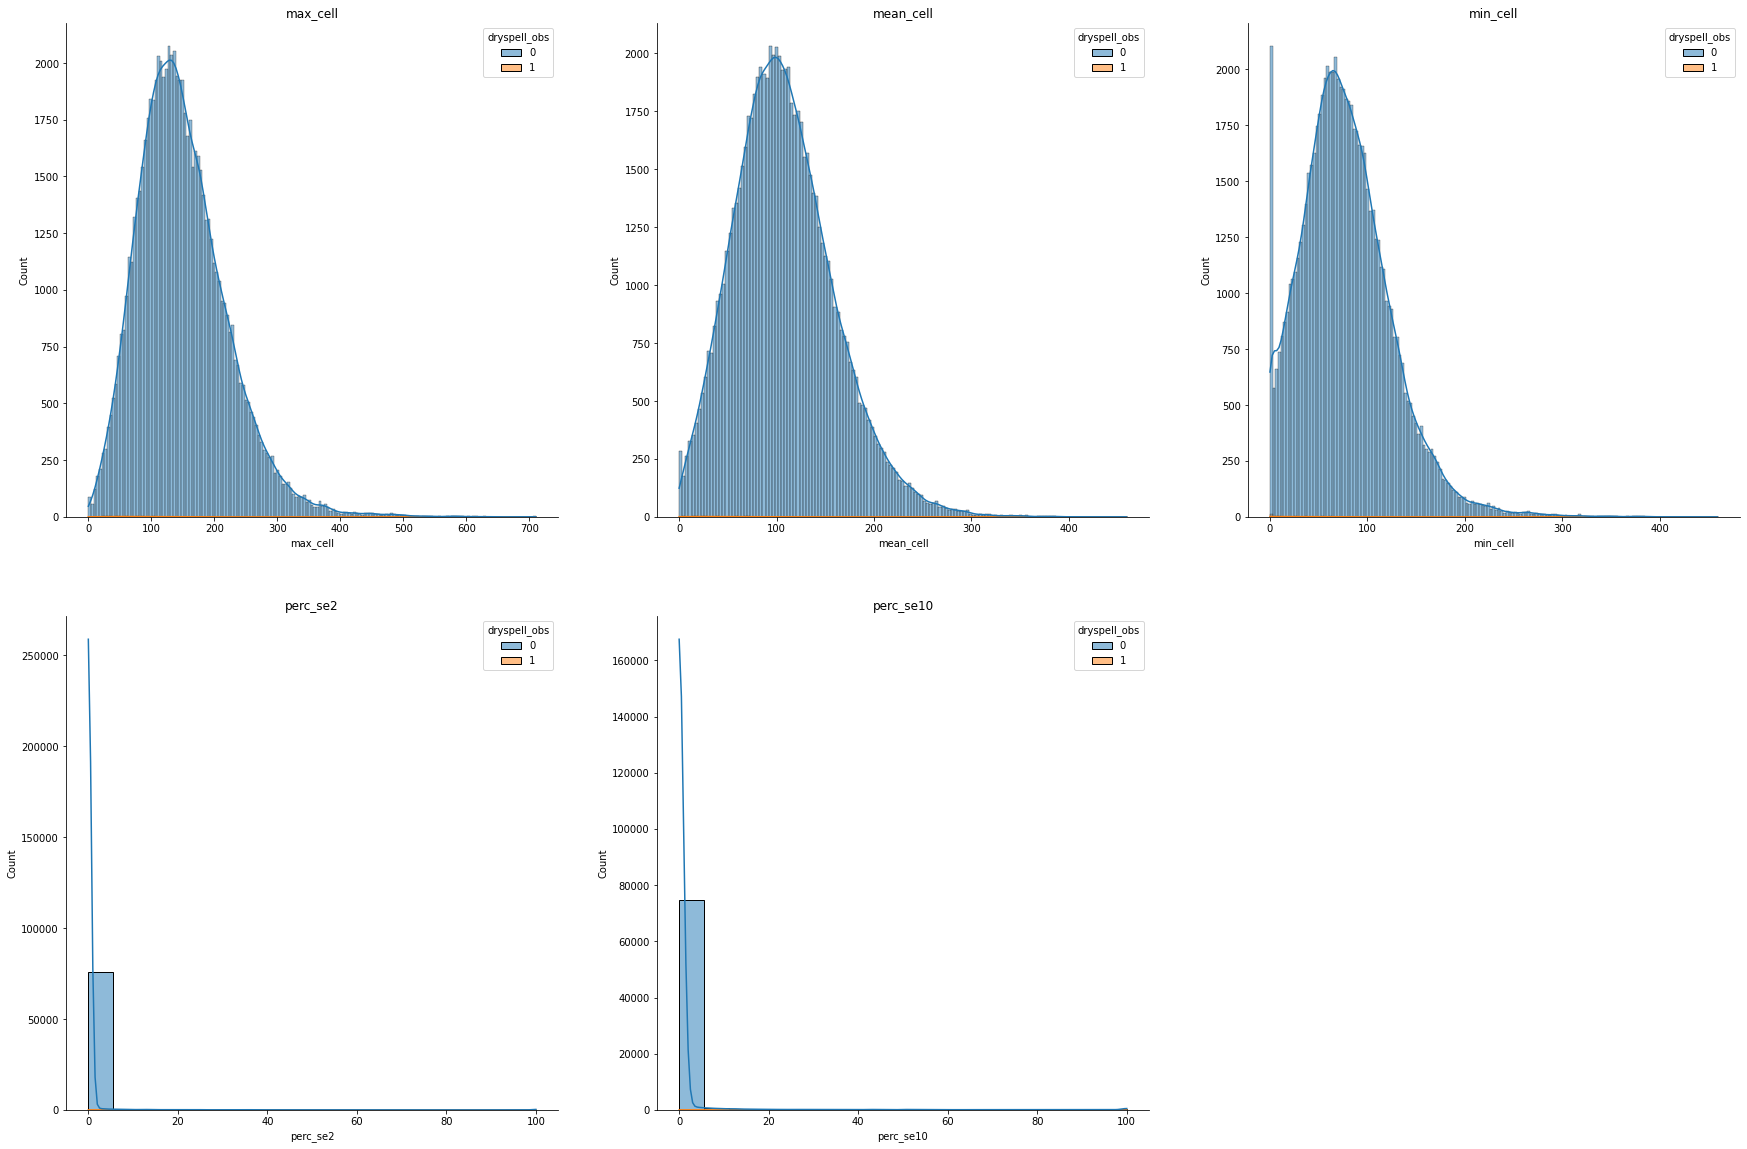

In [92]:
num_plots = len(cg_stats)
colp_num=3
if num_plots==1:
    colp_num=1
rows = math.ceil(num_plots / colp_num)
position = range(1, num_plots + 1)
fig=plt.figure(figsize=(30,20))
for i, s in enumerate(cg_stats):
    ax = fig.add_subplot(rows,colp_num,i+1)
    sns.histplot(df_comb,x=s,ax=ax,stat="count",kde=True,hue="dryspell_obs")
    ax.set_title(s)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

#### Plot raw raster values
Of CHIRPS-GEFS for dates where there is an observed dry spell

In [93]:
#load the raster data
ds_list=[]
for d in df_comb[df_comb.dryspell_obs==1].date.unique():
    d_str=pd.to_datetime(d).strftime("%Y%m%d")
    filename=f"chirpsgefs_africa_{d_str}.tif"
    rds=rioxarray.open_rasterio(os.path.join(chirpsgefs_dir,filename))
    rds=rds.assign_coords({"time":pd.to_datetime(d)})
    rds=rds.sel(band=1)
    ds_list.append(rds)

ds_drys=xr.concat(ds_list,dim="time")

ds_drys=ds_drys.sortby("time")

In [94]:
ds_list[0]

<xarray.DataArray (y: 1600, x: 1500)>
[2400000 values with dtype=float32]
Coordinates:
    band         int64 1
  * y            (y) float64 39.97 39.92 39.87 39.82 ... -39.88 -39.93 -39.98
  * x            (x) float64 -19.97 -19.92 -19.87 -19.82 ... 54.88 54.93 54.98
    spatial_ref  int64 0
    time         datetime64[ns] 2008-02-10
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref

Balaka
Blantyre
Blantyre City
Chikwawa
Chiradzulu
Machinga
Mulanje
Mwanza
Neno
Nsanje
Ntcheu
Ntchisi
Phalombe
Salima
Thyolo
Zomba City


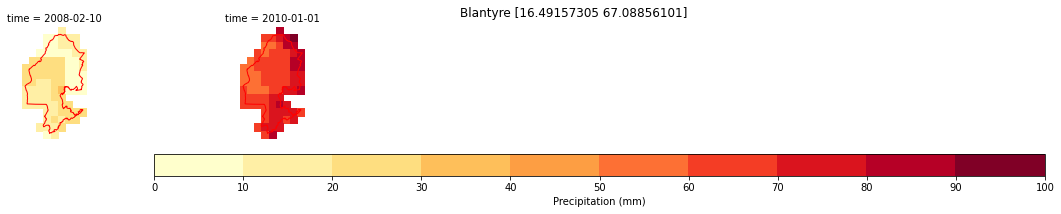

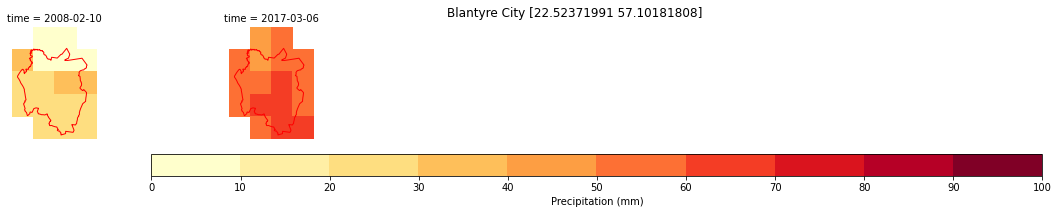

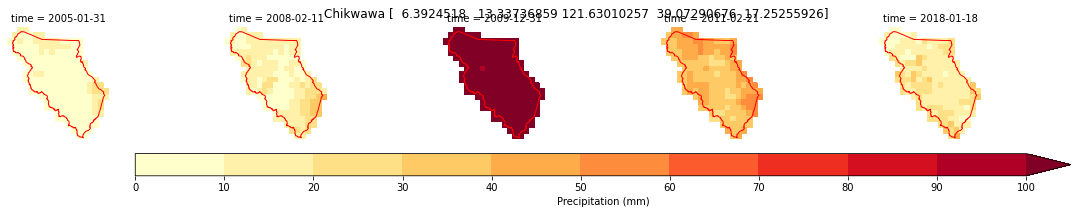

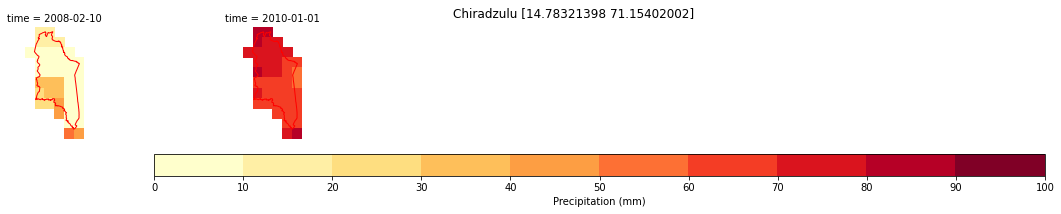

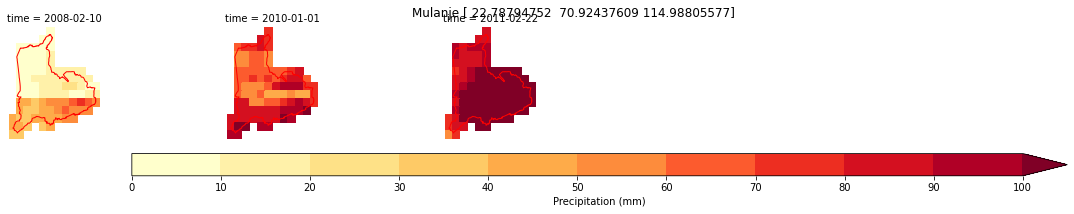

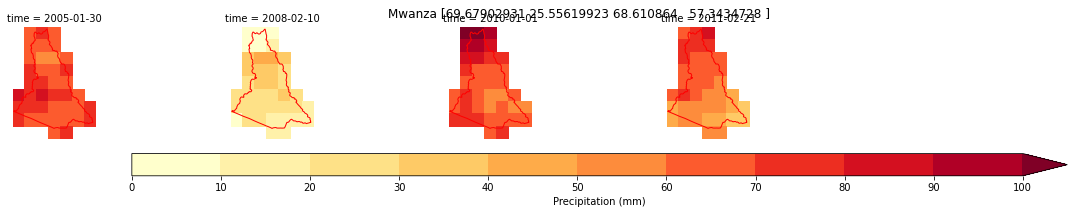

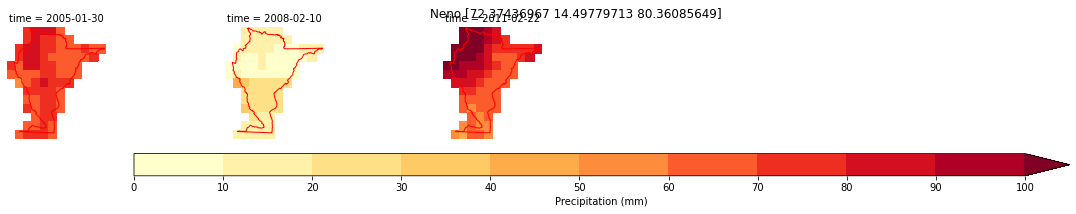

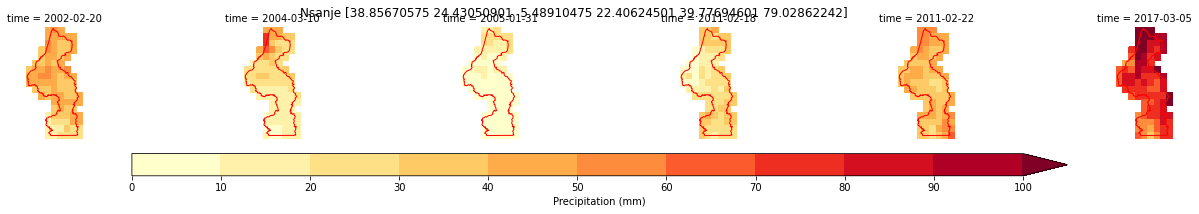

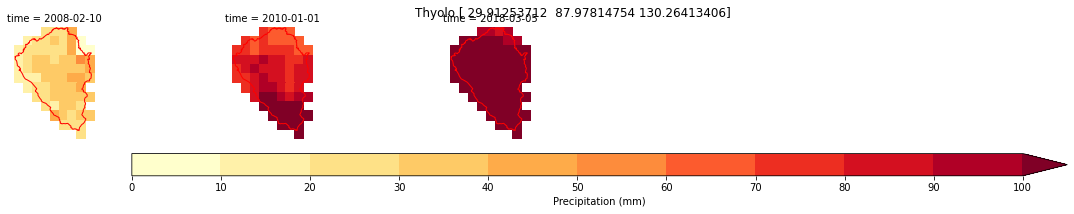

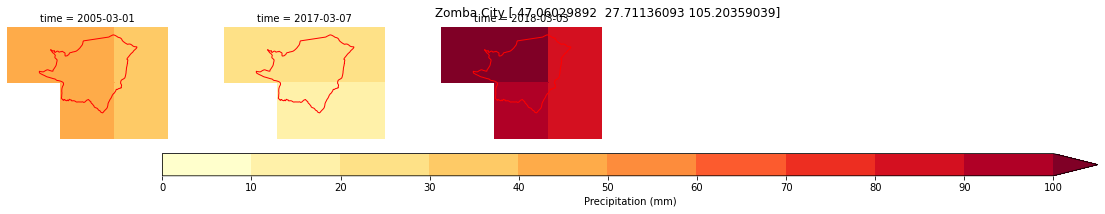

In [95]:
#plot the rasters. Plot per adm2
ds_drys_clip = ds_drys.rio.clip(df_bound_adm2.geometry.apply(mapping), df_bound_adm2.crs, all_touched=True)
bins=np.arange(0,101,10)

# ds_drys_clip.values[~np.isnan(ds_drys_clip.values)].max()

df_comb_ds=df_comb[df_comb.dryspell_obs==1]
for a in df_comb_ds.ADM2_EN.unique():
    print(a)
    df_bound_sel_adm=df_bound_adm2[df_bound_adm2.ADM2_EN==a]
    ds_drys_clip_adm = ds_drys.rio.clip(df_bound_sel_adm.geometry.apply(mapping), df_bound_sel_adm.crs, all_touched=True)
    ds_drys_clip_adm_dates=ds_drys_clip_adm.sel(time=ds_drys_clip_adm.time.isin(df_comb_ds[df_comb_ds.ADM2_EN==a].date.unique()))
    #cannot make the facetgrid if only one occurence. For now leave them out since just exploration, but for completeness should somehow include them
    if len(ds_drys_clip_adm_dates.time)>1:
        g=ds_drys_clip_adm_dates.plot(
        col="time",
        col_wrap=6,
        levels=bins,
        cbar_kwargs={
            "orientation": "horizontal",
            "shrink": 0.8,
            "aspect": 40,
            "pad": 0.1,
            "label":"Precipitation (mm)",
            "ticks": bins
        },
        cmap="YlOrRd",
    )

        for ax in g.axes.flat:
            df_bound_sel_adm.boundary.plot(linewidth=1, ax=ax, color="red")
            ax.axis("off")
        df_comb_ds_adm=df_comb_ds.sort_values(by=['ADM2_EN','date'])[df_comb_ds.ADM2_EN==a]
        g.fig.suptitle(f"{a} {df_comb_ds_adm.mean_cell.values}")



### Discrepancy forecasted and observed rainfall

In [96]:
#read historically observed 14 day rolling sum for all dates (so not only those with dry spells)
df_histobs=pd.read_csv(os.path.join(country_data_processed_dir,"dry_spells","data_mean_values_long.csv"))
df_histobs.date=pd.to_datetime(df_histobs.date)

#add start of the rolling sum 
df_histobs["date_start"]=df_histobs.date-timedelta(days=14)

In [97]:
#add adm2 name
df_histobs=df_histobs.merge(df_bound_adm2[["ADM1_EN","ADM2_EN","ADM2_PCODE"]],left_on="pcode",right_on="ADM2_PCODE")

In [98]:
#merge forecast and observed
#only include dates within the rainy season
df_histformerg=df_histobs.merge(df_chirpsgefs,how="right",left_on=["date_start","ADM2_EN"],right_on=["date","ADM2_EN"],suffixes=("obs","forec"))

In [99]:
df_histformerg["diff_precip"]=df_histformerg["rollsum_15d"]-df_histformerg["mean_cell"]
df_histformerg["diff_forecobs"]=df_histformerg["mean_cell"]-df_histformerg["rollsum_15d"]

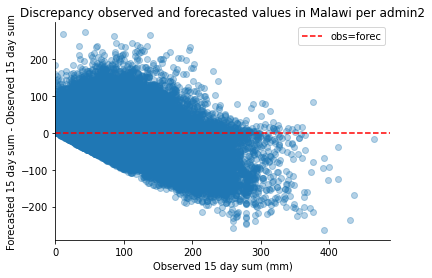

In [100]:
g=sns.regplot(data=df_histformerg,y="diff_forecobs",x="rollsum_15d",scatter_kws = {'alpha' : 1/3},fit_reg=False)
ax=g.axes
ax.set_xlabel("Observed 15 day sum (mm)")
ax.set_ylabel("Forecasted 15 day sum - Observed 15 day sum")
ax.set_title("Discrepancy observed and forecasted values in Malawi per admin2")
ax.axhline(0, ls='--',color="red",label="obs=forec")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(0,ax.get_xlim()[1])
# ax.plot(np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],50),np.linspace(-ax.get_xlim()[0],-ax.get_xlim()[1],50),ls="--",label="forec=0")
plt.legend()
# plt.savefig(os.path.join(country_data_exploration_dir,"dryspells","plot_MWI_CHIRPSGEFS_CHIRPS.png"))

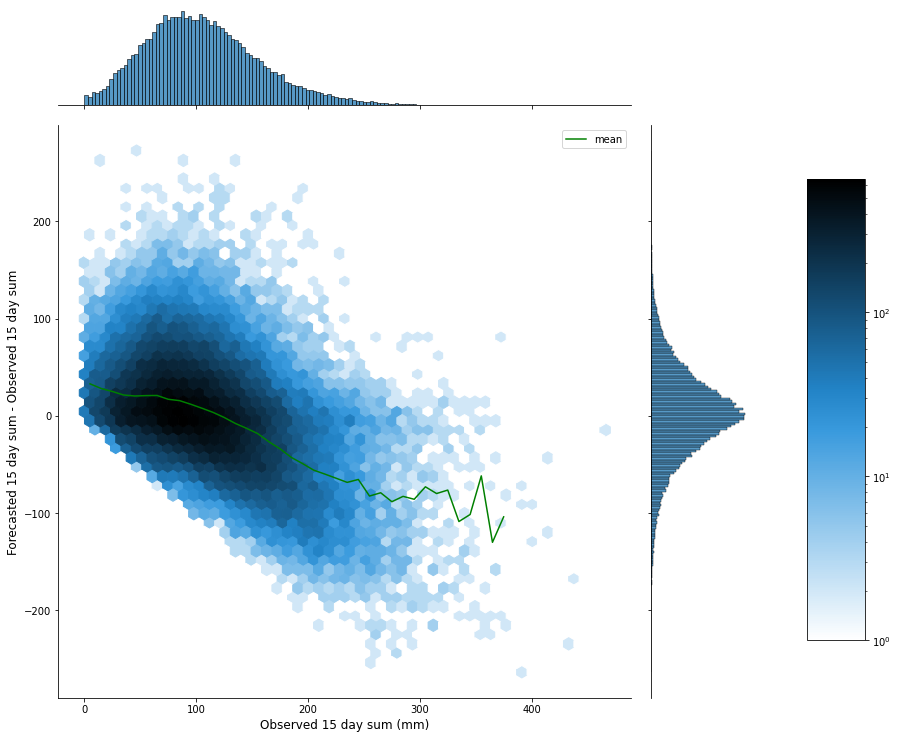

In [101]:
bins = np.arange(0,df_histformerg.rollsum_15d.max(),10)
group = df_histformerg.groupby(pd.cut(df_histformerg.rollsum_15d, bins))
plot_centers = (bins [:-1] + bins [1:])/2
plot_values = group.diff_forecobs.mean()
g=sns.jointplot(data=df_histformerg,y="diff_forecobs",x="rollsum_15d", kind="hex",height=16,joint_kws={ 'bins':'log'})
# ax=g.axes
g.set_axis_labels("Observed 15 day sum (mm)", "Forecasted 15 day sum - Observed 15 day sum", fontsize=12)
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)  # shrink fig so cbar is visible
g.ax_joint.plot(plot_centers,plot_values,color="green",label="mean")
g.ax_joint.legend()
# make new ax object for the cbar
cbar_ax = g.fig.add_axes([.85, .25, .05, .4])  # x, y, width, height
plt.colorbar(cax=cbar_ax)
# ax.set_xlabel("Observed 15 day sum (mm)")
# ax.set_ylabel("Forecasted 15 day sum - Observed 15 day sum")
# ax.set_title("Discrepancy observed and forecasted values in Malawi per admin2")
# plt.savefig(os.path.join(country_data_exploration_dir,"dryspells","plot_MWI_chirpsgefs_density.png"))

In [102]:
len(df_histformerg[df_histformerg.rollsum_15d<=2])

164

In [104]:
len(df_histformerg)

77184

In [105]:
df_histformerg.groupby("during_rainy_season_bin").sum()

,ID,total_prec,year,month,day,rollsum_10d,rollsum_14d,rollsum_15d,rainy_day_bin,rainy_season_duration,...,ADM2ALT1EN,ADM2ALT2EN,validTo,max_cell,min_cell,mean_cell,perc_se2,perc_se10,diff_precip,diff_forecobs
during_rainy_season_bin,,,,,,,,,,,,,,,,,,,,,
0.0,45035.0,8247.158696,5474660.0,9267.0,50541.0,8.185190e+04,1.159198e+05,1.245508e+05,538.0,298530.0,...,0.0,0.0,0.0,2.474261e+05,8.112461e+04,1.435505e+05,13806.351597,29264.752491,-18999.651226,18999.651226
1.0,1164609.0,485734.127632,140679805.0,259502.0,1090261.0,5.020502e+06,7.107073e+06,7.640691e+06,35315.0,9214871.0,...,0.0,0.0,0.0,1.060188e+07,5.579976e+06,7.692469e+06,33972.093754,75171.449323,-51778.451022,51778.451022


In [106]:
df_histformerg.groupby("during_rainy_season_bin").count()

,ID,pcode,season_approx,dateobs,total_prec,year,month,day,rollsum_10d,rollsum_14d,...,validOn,validTo,max_cell,min_cell,mean_cell,perc_se2,perc_se10,date_forec_end,diff_precip,diff_forecobs
during_rainy_season_bin,,,,,,,,,,,,,,,,,,,,,
0.0,2722,2722,2722,2722,2722,2722,2722,2722,2722,2722,...,2722,0,2722,2722,2722,2722,2722,2722,2722,2722
1.0,69993,69993,69993,69993,69993,69993,69993,69993,69993,69993,...,69993,0,69993,69993,69993,69993,69993,69993,69993,69993


In [107]:
df_histformerg[df_histformerg.during_rainy_season_bin==0].dateobs.dt.month.min()

3

In [108]:
df_histformerg[df_histformerg.during_rainy_season_bin==0][["dateobs","ADM2_EN"]]

,dateobs,ADM2_EN
326,2002-03-17,Balaka
327,2002-03-18,Balaka
328,2002-03-19,Balaka
329,2002-03-20,Balaka
330,2002-03-21,Balaka
...,...,...
76922,2018-04-22,Zomba City
76923,2018-04-23,Zomba City
76924,2018-04-24,Zomba City
76925,2018-04-25,Zomba City


In [109]:
len(df_histformerg[df_histformerg.mean_cell<=2])

201

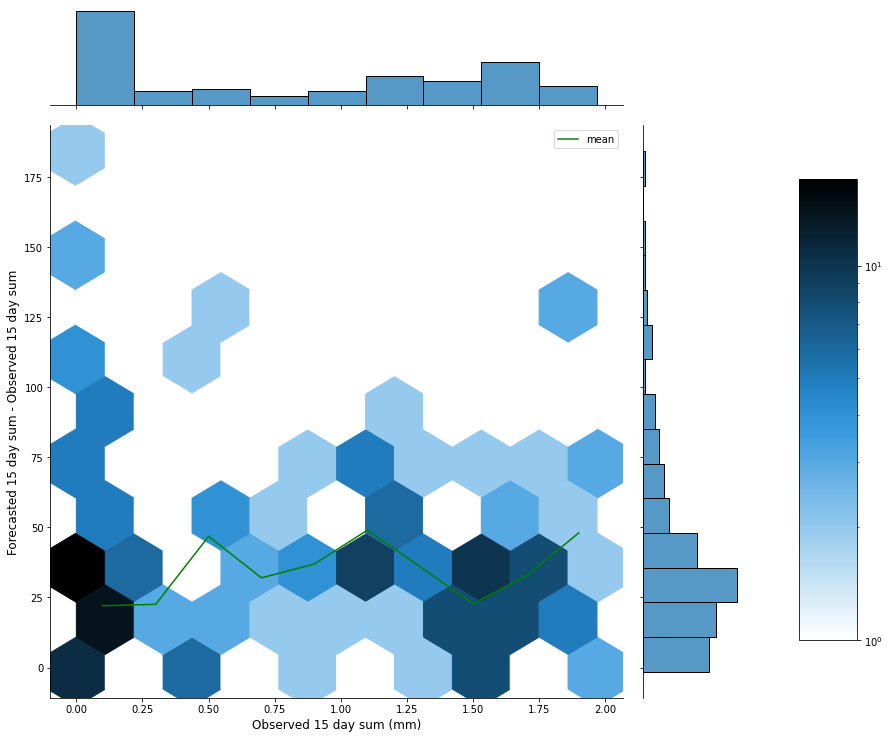

In [110]:
df_sel=df_histformerg[df_histformerg.rollsum_15d<=2].sort_values("rollsum_15d")
bins = np.arange(0,df_sel.rollsum_15d.max()+2,0.2)
group = df_sel.groupby(pd.cut(df_sel.rollsum_15d, bins))
plot_centers = (bins [:-1] + bins [1:])/2
plot_values = group.diff_forecobs.mean()
g=sns.jointplot(data=df_sel,y="diff_forecobs",x="rollsum_15d", kind="hex",height=16,joint_kws={ 'bins':'log'})
# ax=g.axes
g.set_axis_labels("Observed 15 day sum (mm)", "Forecasted 15 day sum - Observed 15 day sum", fontsize=12)
# g.ax_joint.plot(df_sel.rollsum_15d,df_sel.diff_forecobs,alpha=0.3)
g.ax_joint.plot(plot_centers,plot_values,color="green",label="mean")#,legend=True)
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)  # shrink fig so cbar is visible
# make new ax object for the cbar
cbar_ax = g.fig.add_axes([.85, .25, .05, .4])  # x, y, width, height
plt.colorbar(cax=cbar_ax)
g.ax_joint.legend()
# ax.set_xlabel("Observed 15 day sum (mm)")
# ax.set_ylabel("Forecasted 15 day sum - Observed 15 day sum")
# ax.set_title("Discrepancy observed and forecasted values in Malawi per admin2")
# plt.savefig(os.path.join(country_data_exploration_dir,"dryspells","plot_MWI_chirpsgefs_density2mm.png"))

In [111]:
# g=sns.regplot(data=df_histformerg,y="diff_precip",x="rollsum_15d",scatter_kws = {'alpha' : 1/3},fit_reg=False)
# ax=g.axes
# ax.set_xlabel("Observed 15 day sum (mm)")
# ax.set_ylabel("Observed 15 day sum - Forecasted 15 day sum")
# ax.set_title("Discrepancy observed and forecasted values")
# ax.axhline(0, ls='--',color="red",label="Obs=Forec")
# print(ax.get_xlim())
# ax.set_xlim(0,ax.get_xlim()[1])
# ax.plot(np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],50),np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],50),ls="--",label="Forec=0")
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# plt.legend()

### Correlation different thresholds

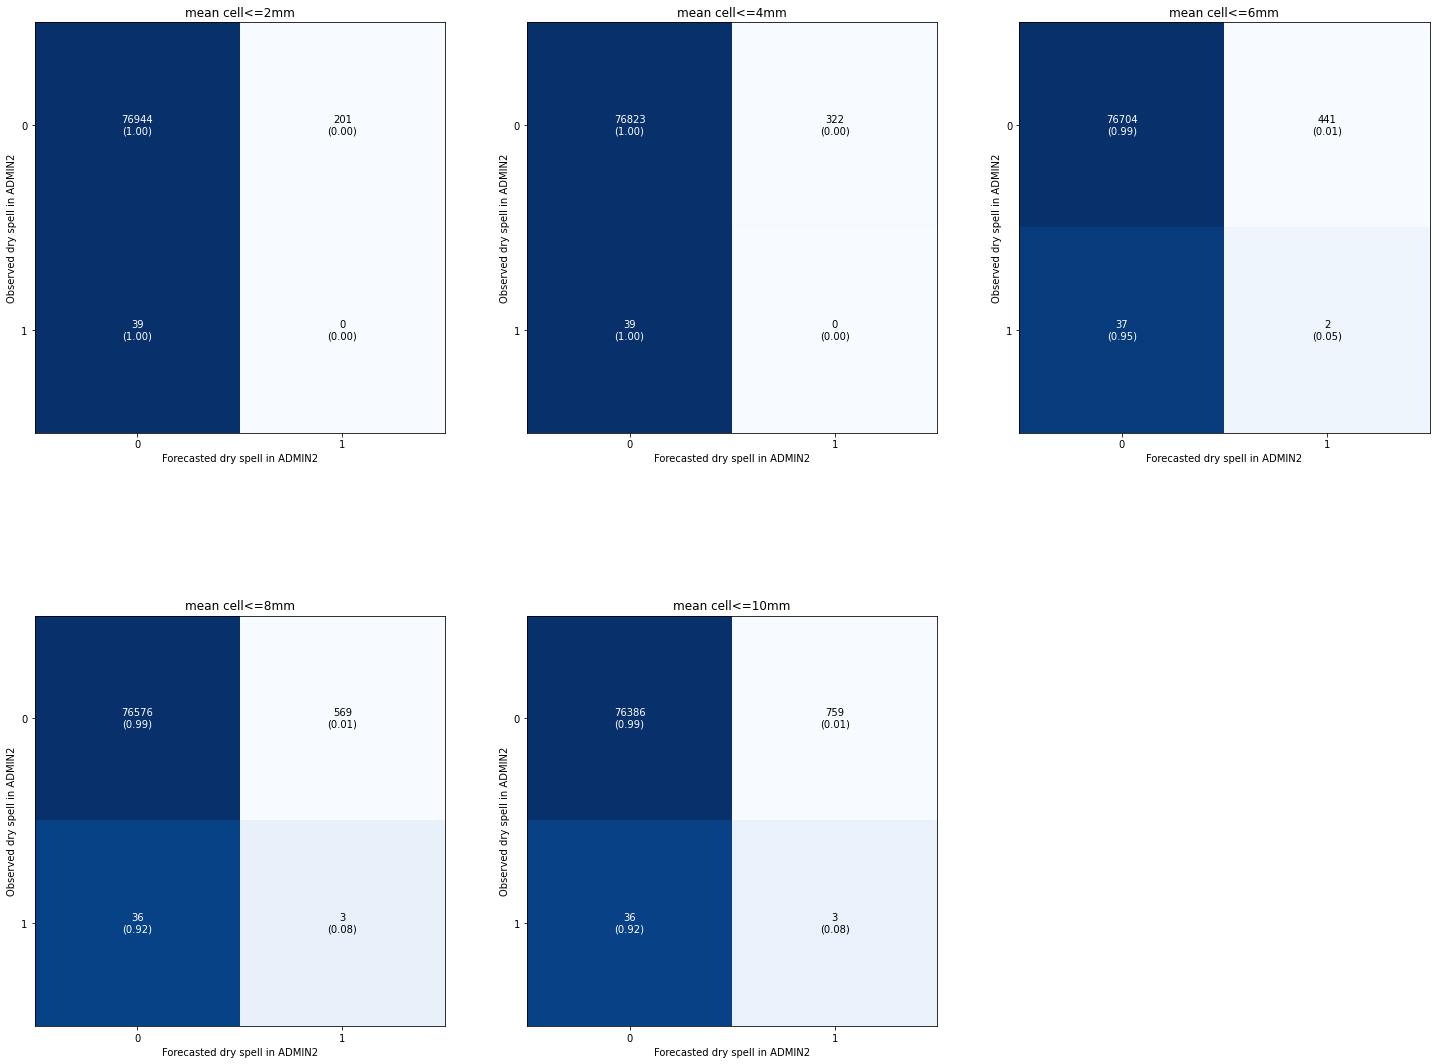

In [112]:
#compute the contigency table when using mean cell for different thresholds
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
t_list=[2,4,6,8,10]
num_plots = len(t_list)
colp_num=3
if num_plots==1:
    colp_num=1
rows = math.ceil(num_plots / colp_num)
position = range(1, num_plots + 1)
fig=plt.figure(figsize=(25,20))
for i,t in enumerate(t_list):
    y_target =    df_comb["dryspell_obs"]
    y_predicted = np.where(df_comb["mean_cell"]<=t,1,0)
    ax = fig.add_subplot(rows,colp_num,i+1)
    cm = confusion_matrix(y_target=y_target, 
                          y_predicted=y_predicted)

    plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True,axis=ax) #,class_names=["No","Yes"])
    ax.set_ylabel("Observed dry spell in ADMIN2")
    ax.set_xlabel("Forecasted dry spell in ADMIN2")
    ax.set_title(f"mean cell<={t}mm")

In [113]:
#set definition of forecasted dry spell as max cell having not more than 2 mm of rains in 15 days period
df_comb["dryspell_forec"]=np.where(df_comb.mean_cell<=2,1,0)

Text(0.5, 1.0, 'Observed and forecasted dryspells')

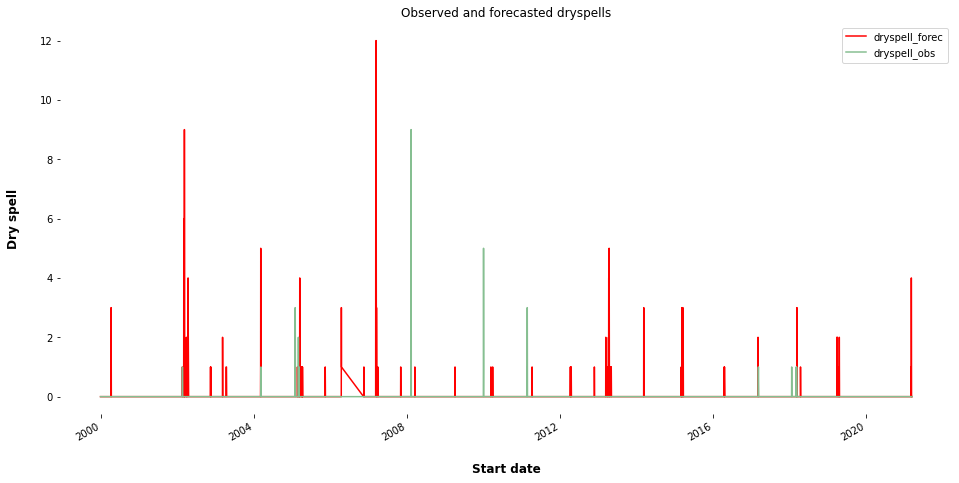

In [114]:
#number of adm2s with dryspell for forecasted and observed over time
#the diagonal lines are caused by the last day of a rainy season having a forecasted dry spell
from matplotlib.ticker import StrMethodFormatter
fig,ax=plt.subplots()
df_comb_date=df_comb.groupby("date",as_index=False).sum()
df_comb_date.sort_values(by="date").plot(x="date",y="dryspell_forec" ,figsize=(16, 8), color='red',legend=True,ax=ax)
df_comb_date.sort_values(by="date").plot(x="date",y="dryspell_obs" ,figsize=(16, 8), color='#86bf91',legend=True,ax=ax)

# Set x-axis label
ax.set_xlabel("Start date", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("Dry spell", labelpad=20, weight='bold', size=12)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.title(f"Observed and forecasted dryspells")

In [115]:
#understand monthly patterns observed vs forecasted
df_comb["month"]=df_comb.date.dt.month

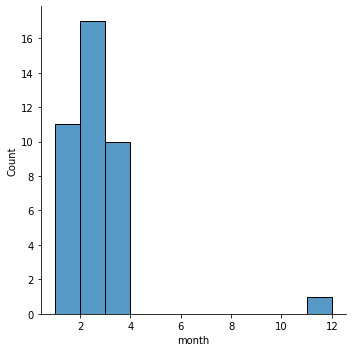

In [116]:
#observed dry spells per month
sns.displot(df_comb[df_comb.dryspell_obs==1],bins=range(df_comb.month.min(),df_comb.month.max()+1),x="month")

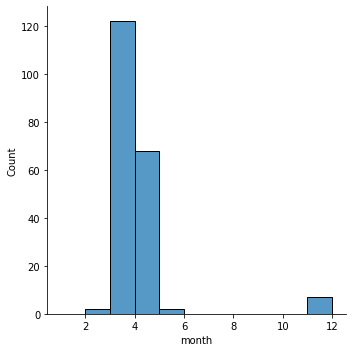

In [117]:
#forecasted dry spells per month
sns.displot(df_comb[df_comb.dryspell_forec==1],bins=range(df_comb.month.min(),df_comb.month.max()+1),x="month")

### Correlations

None of the mean cell boundaries really captures the dry spell and do results in lot of false positives.. When using the max, it doesn't get better

##### Understand differences patterns observed and forecasted dry spells
- Dry spell is at least 14 days while forecasted period is 15 days --> can be a reason for underpredicting
- [WHEN USING MAX TO COMPUTE OBSERVED DRY SPELLS] Definition of observed dry spell is stricter than forecasted --> can be a reason for overpredicting


In [118]:
#sum of dryspells per adm2, doesn't mean they occured on the same dates
#could add fraction obs/forec
df_comb.groupby("ADM2_EN").sum()[["dryspell_forec","dryspell_obs"]]#.date.sort_values().unique()

,dryspell_forec,dryspell_obs
ADM2_EN,,
Balaka,5,1
Blantyre,2,2
Blantyre City,4,2
Chikwawa,14,5
Chiradzulu,2,2
Chitipa,3,0
Dedza,2,0
Dowa,5,0
Karonga,5,0


In [119]:
# df_comb.drop_duplicates("ADM2_EN").groupby("ADM1_EN").count()

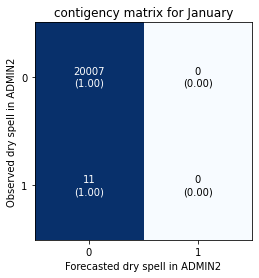

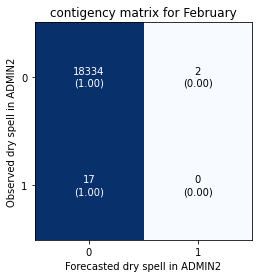

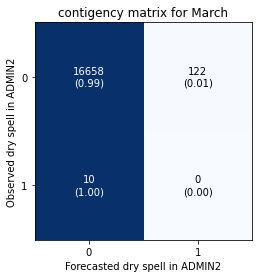

/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/mlxtend/plotting/plot_confusion_matrix.py:76: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


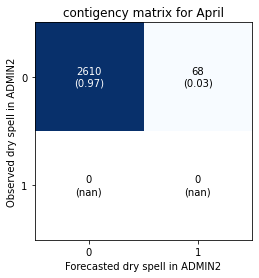

/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/mlxtend/plotting/plot_confusion_matrix.py:76: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


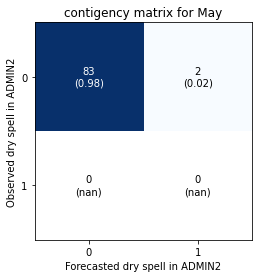

/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/mlxtend/plotting/plot_confusion_matrix.py:76: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


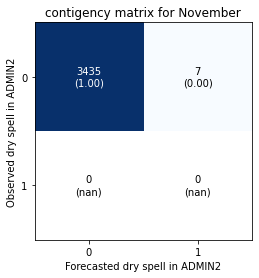

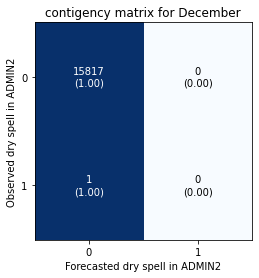

In [120]:
#compute the contigency table per month
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

for m in df_comb.sort_values(by="month").month.unique():

    y_target =    df_comb.loc[df_comb.month==m,"dryspell_obs"]
    y_predicted = df_comb.loc[df_comb.month==m,"dryspell_forec"]

    cm = confusion_matrix(y_target=y_target, 
                          y_predicted=y_predicted)
#     print(cm)
#     print(calendar.month_name[m])
#     print(f"contigency matrix for {pd.to_datetime(m).strftime('%B')}")
    fig, ax = plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True) #,class_names=["No","Yes"])
    ax.set_ylabel("Observed dry spell in ADMIN2")
    ax.set_xlabel("Forecasted dry spell in ADMIN2")
#     print(m)
    ax.set_title(f"contigency matrix for {calendar.month_name[m]}")
    plt.show()

#### correlation number of admin2s with observed and forecasted dry spell

In [121]:
#compute number of adm2s with dryspell per date
df_numadm=df_comb.groupby("date")[["dryspell_obs","dryspell_forec"]].sum()

In [122]:
df_numadm

,dryspell_obs,dryspell_forec
date,,
2000-01-01,0,0
2000-01-02,0,0
2000-01-03,0,0
2000-01-04,0,0
2000-01-05,0,0
...,...,...
2021-03-08,0,0
2021-03-09,0,0
2021-03-10,0,0


<AxesSubplot:xlabel='dryspell_obs', ylabel='dryspell_forec'>

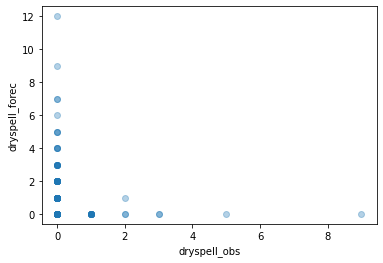

In [123]:
#darker shade means higher density of values
#-->not really clear pattern..
sns.regplot(data = df_numadm, x = 'dryspell_obs', y = 'dryspell_forec', fit_reg = False,
            scatter_kws = {'alpha' : 1/3})#,x_jitter = 0.2, y_jitter = 0.2)

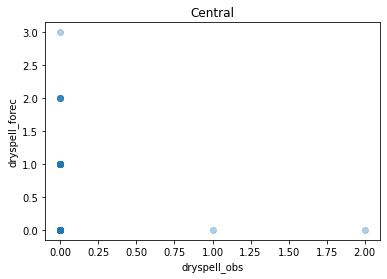

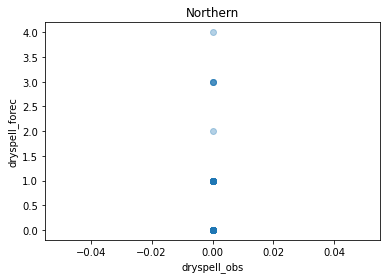

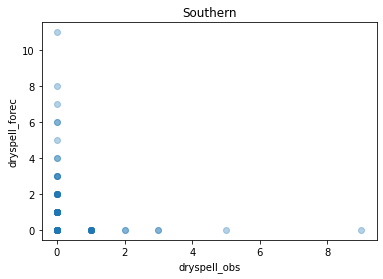

In [124]:
df_comb=df_comb.merge(df_bound_adm2[["ADM1_EN","ADM2_EN"]],on="ADM2_EN",how="left")
df_numadm1=df_comb.groupby(["date","ADM1_EN"],as_index=False)[["dryspell_obs","dryspell_forec"]].sum()

for a in df_numadm1.ADM1_EN.unique():
    g=sns.regplot(data = df_numadm1[df_numadm1.ADM1_EN==a], x = 'dryspell_obs', y = 'dryspell_forec', fit_reg = False,
            scatter_kws = {'alpha' : 1/3})#,x_jitter = 0.2, y_jitter = 0.2)
    g.axes.set_title(a)
    plt.show()

[[3232  106]
 [  19    1]]


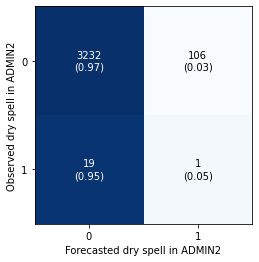

In [125]:
#compute the contigency table per date
#Damnn that correlation between obsrved and forecasted is waay less than I expected.. 
#Need to further understand why and if this is really the case or bug somewhere
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

df_comb_date=df_comb.groupby("date",as_index=False).sum()
df_comb_date["dryspell_obs_bool"]=np.where(df_comb_date.dryspell_obs>=1,1,0)
df_comb_date["dryspell_forec_bool"]=np.where(df_comb_date.dryspell_forec>=1,1,0)

y_target =    df_comb_date["dryspell_obs_bool"]
y_predicted = df_comb_date["dryspell_forec_bool"]

cm = confusion_matrix(y_target=y_target, 
                      y_predicted=y_predicted)
print(cm)

fig, ax = plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True) #,class_names=["No","Yes"])
ax.set_ylabel("Observed dry spell in ADMIN2")
ax.set_xlabel("Forecasted dry spell in ADMIN2")
plt.show()

[[87 29]
 [ 6  5]]


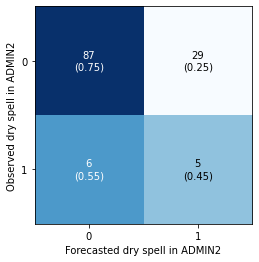

In [126]:
#compute the contigency table per date
#Damnn that correlation between obsrved and forecasted is waay less than I expected.. 
#Need to further understand why and if this is really the case or bug somewhere
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

df_comb["date_month"]=df_comb.date.dt.to_period("M")
df_comb_month=df_comb.groupby("date_month",as_index=False).sum()
df_comb_month["dryspell_obs_bool"]=np.where(df_comb_month.dryspell_obs>=1,1,0)
df_comb_month["dryspell_forec_bool"]=np.where(df_comb_month.dryspell_forec>=1,1,0)

y_target =    df_comb_month["dryspell_obs_bool"]
y_predicted = df_comb_month["dryspell_forec_bool"]

cm = confusion_matrix(y_target=y_target, 
                      y_predicted=y_predicted)
print(cm)

fig, ax = plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True) #,class_names=["No","Yes"])
ax.set_ylabel("Observed dry spell in ADMIN2")
ax.set_xlabel("Forecasted dry spell in ADMIN2")
plt.show()

### Correlation 15 day rolling sum

In [127]:
#read historically observed 14 day rolling sum for all dates (so not only those with dry spells)
df_histobs=pd.read_csv(os.path.join(country_data_processed_dir,"dry_spells","data_mean_values_long.csv"))
df_histobs.date=pd.to_datetime(df_histobs.date)

#add start of the rolling sum 
df_histobs["date_start"]=df_histobs.date-timedelta(days=14)

In [128]:
#add adm2 name
df_histobs=df_histobs.merge(df_bound_adm2[["ADM1_EN","ADM2_EN","ADM2_PCODE"]],left_on="pcode",right_on="ADM2_PCODE")

In [129]:
#merge forecast and observed
#only include dates within the rainy season
df_roll=df_histobs.merge(df_chirpsgefs,how="right",left_on=["date_start","ADM2_EN"],right_on=["date","ADM2_EN"],suffixes=("obs","forec"))

In [130]:
df_roll.columns

Index(['ID', 'pcode', 'season_approx', 'dateobs', 'total_prec', 'year',
       'month', 'day', 'rollsum_10d', 'rollsum_14d', 'rollsum_15d',
       'rainy_day_bin', 'onset_date', 'cessation_date',
       'rainy_season_duration', 'onset_month', 'cessation_month',
       'during_rainy_season_bin', 'nth_day_of_rainy_season',
       'rollsum_14d_less_than_2_bin', 'rollsum_15d_less_than_2_bin',
       'date_start', 'ADM1_ENobs', 'ADM2_EN', 'ADM2_PCODEobs', 'Shape_Leng',
       'Shape_Area', 'ADM2_PCODEforec', 'ADM2_REF', 'ADM2ALT1EN', 'ADM2ALT2EN',
       'ADM1_ENforec', 'ADM1_PCODE', 'ADM0_EN', 'ADM0_PCODE', 'dateforec',
       'validOn', 'validTo', 'max_cell', 'min_cell', 'mean_cell', 'perc_se2',
       'perc_se10', 'date_forec_end'],
      dtype='object')

In [131]:
df_roll["dryspell_obs"]=np.where(df_roll.rollsum_15d<=2,1,0)

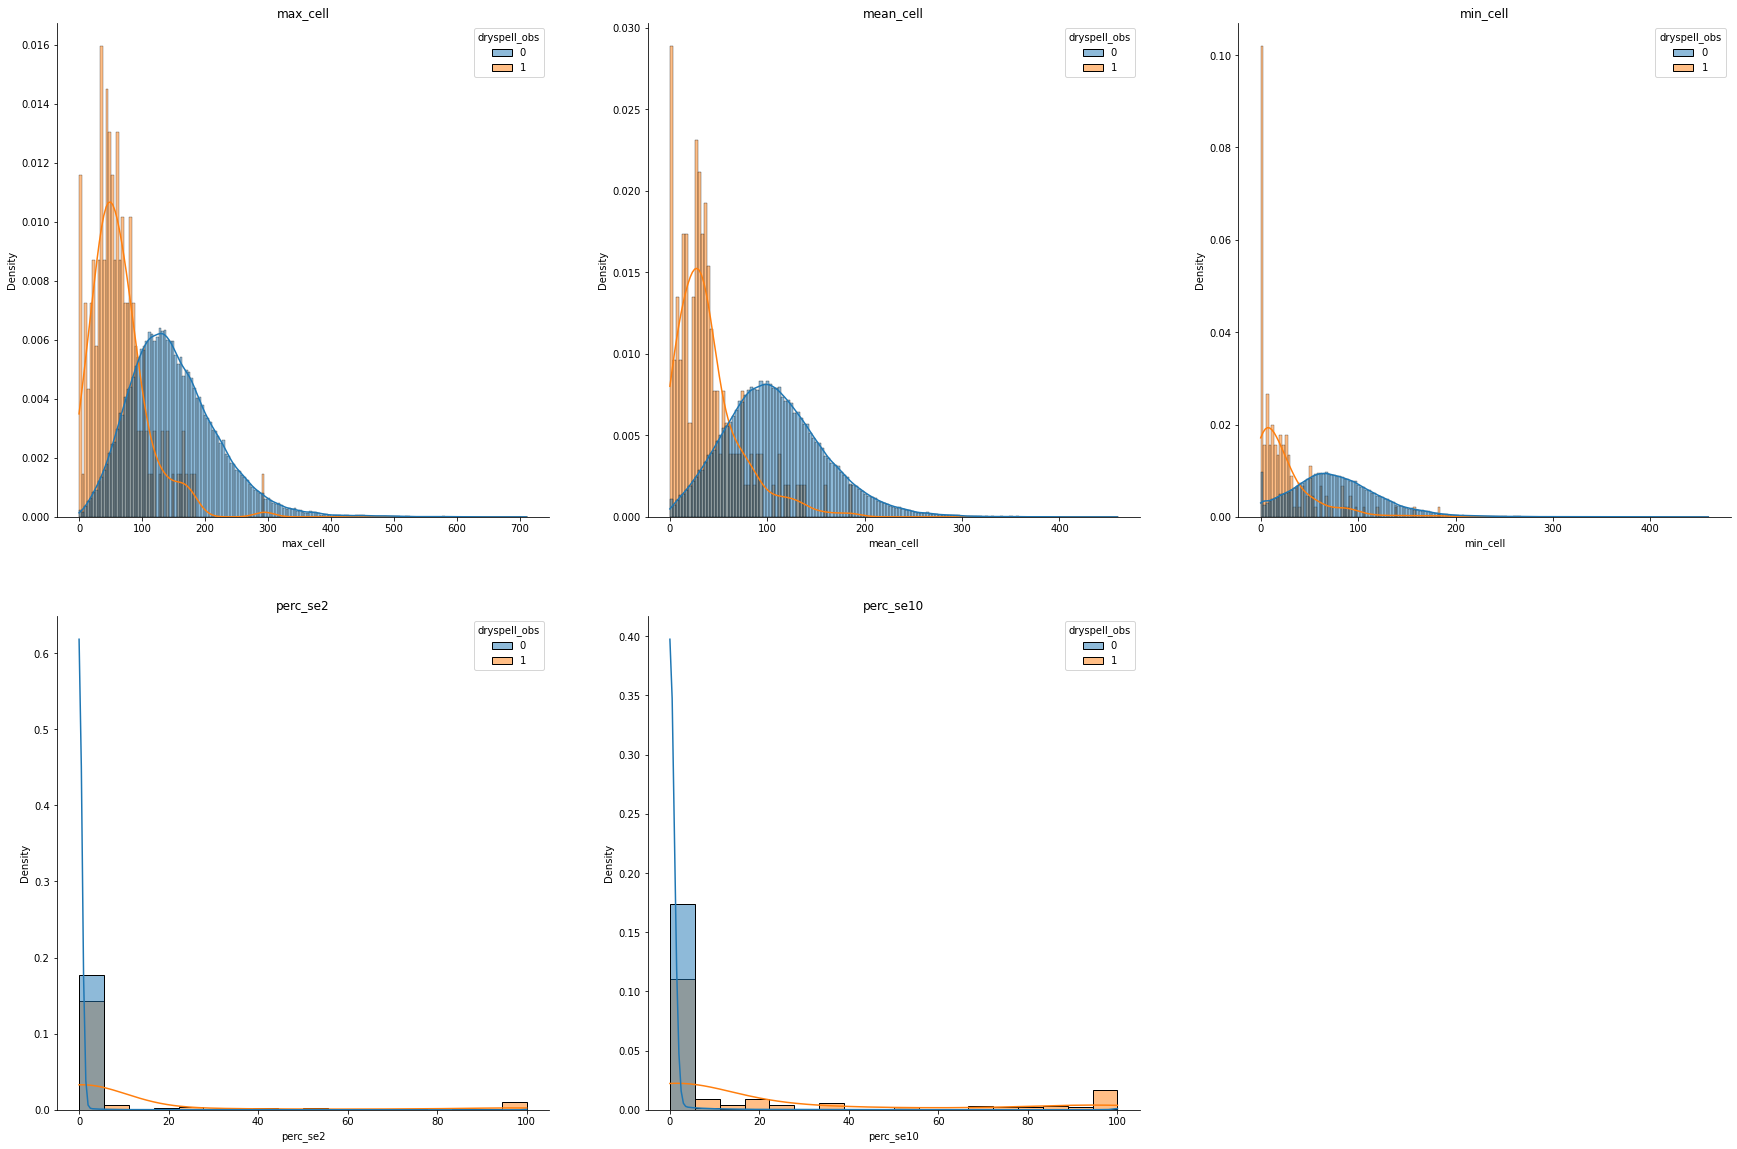

In [132]:
num_plots = len(cg_stats)
colp_num=3
if num_plots==1:
    colp_num=1
rows = math.ceil(num_plots / colp_num)
position = range(1, num_plots + 1)
fig=plt.figure(figsize=(30,20))
for i, s in enumerate(cg_stats):
    ax = fig.add_subplot(rows,colp_num,i+1)
    sns.histplot(df_roll,x=s,ax=ax,stat="density",common_norm=False,kde=True,hue="dryspell_obs")
    ax.set_title(s)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

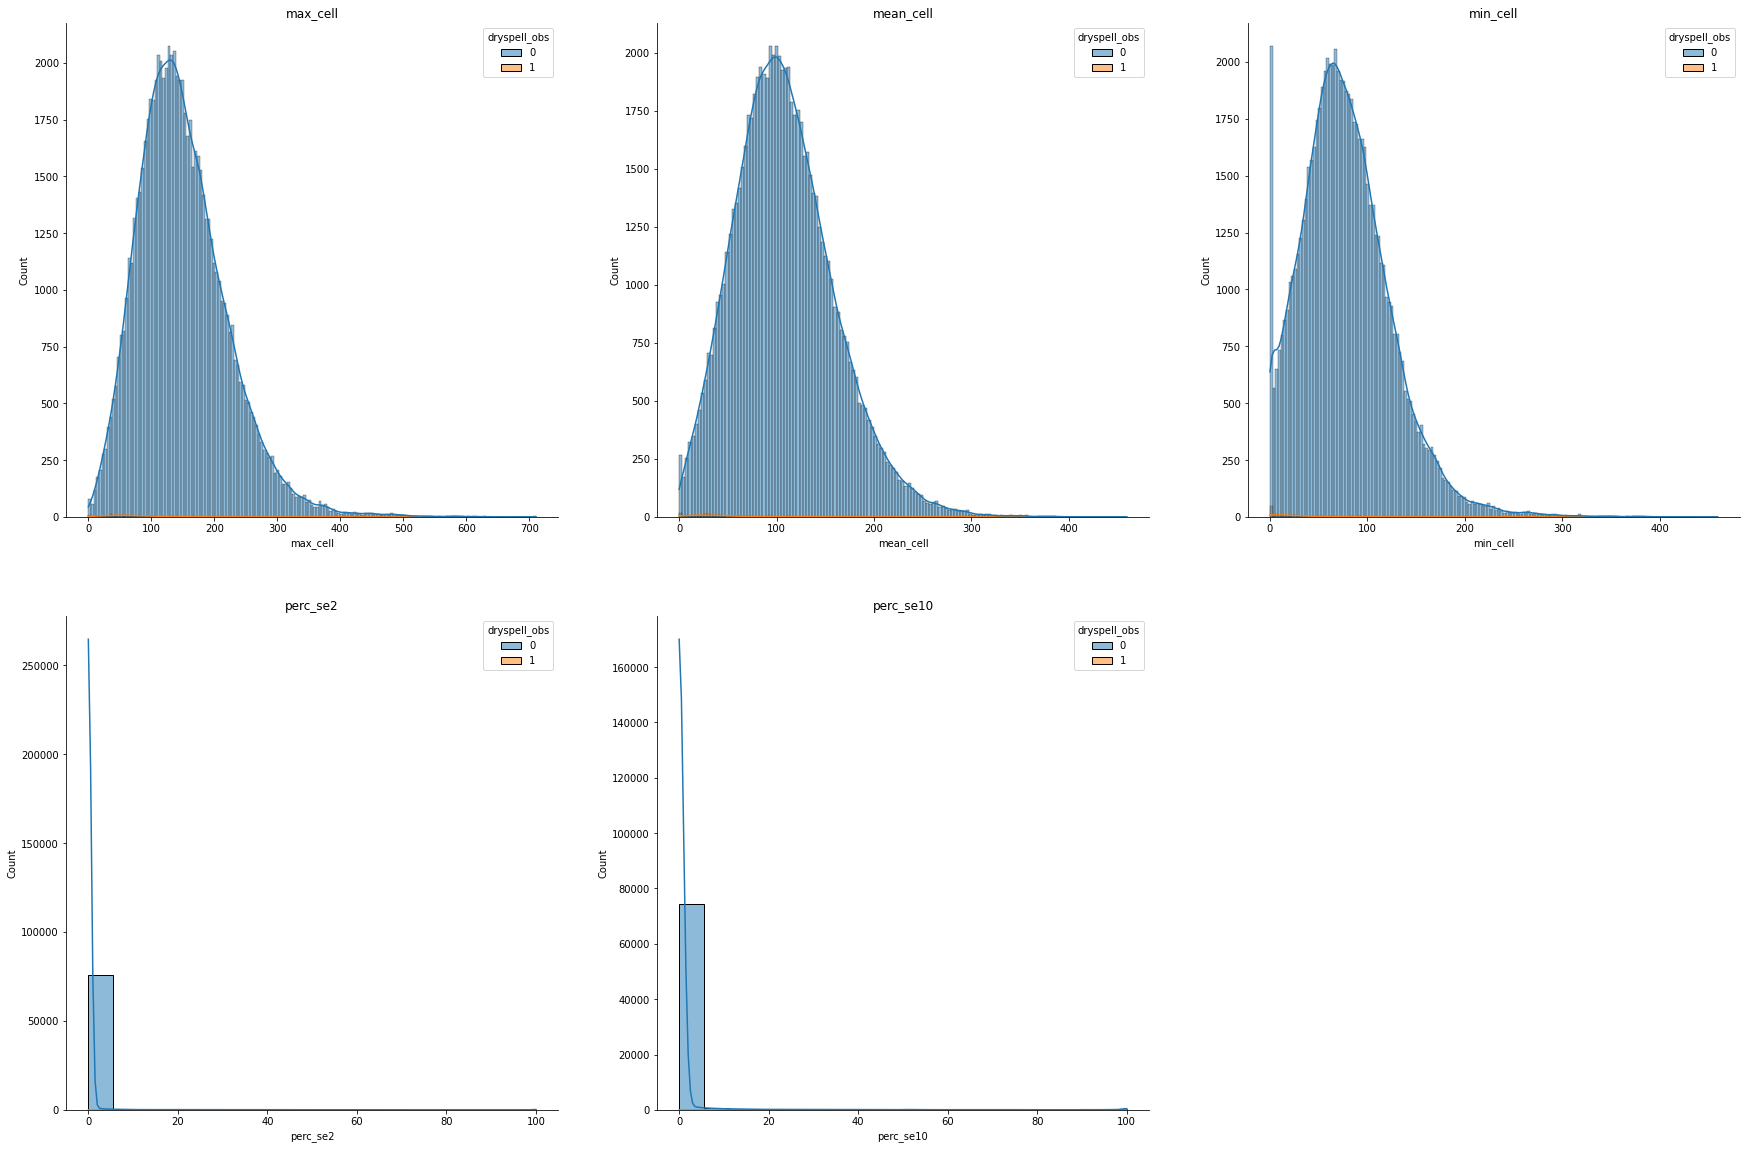

In [133]:
num_plots = len(cg_stats)
colp_num=3
if num_plots==1:
    colp_num=1
rows = math.ceil(num_plots / colp_num)
position = range(1, num_plots + 1)
fig=plt.figure(figsize=(30,20))
for i, s in enumerate(cg_stats):
    ax = fig.add_subplot(rows,colp_num,i+1)
    sns.histplot(df_roll,x=s,ax=ax,stat="count",kde=True,hue="dryspell_obs")
    ax.set_title(s)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

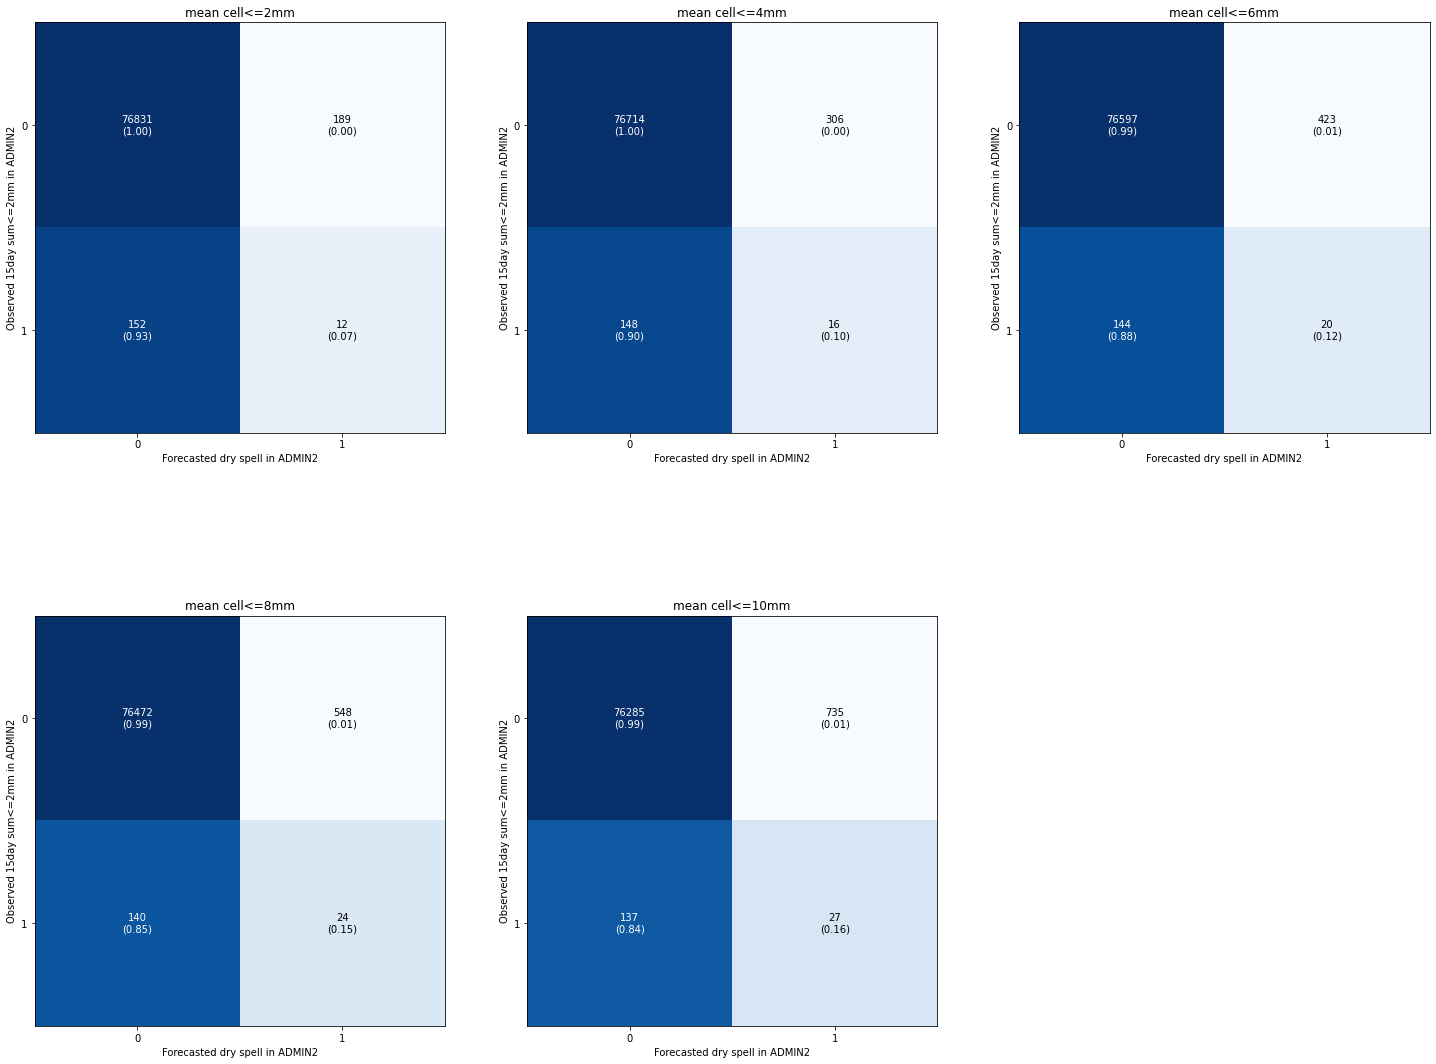

In [134]:
#compute the contigency table when using mean cell for different thresholds
t_list=[2,4,6,8,10]
num_plots = len(t_list)
colp_num=3
if num_plots==1:
    colp_num=1
rows = math.ceil(num_plots / colp_num)
position = range(1, num_plots + 1)
fig=plt.figure(figsize=(25,20))
for i,t in enumerate(t_list):
    y_target =    df_roll["dryspell_obs"]
    y_predicted = np.where(df_roll["mean_cell"]<=t,1,0)
    ax = fig.add_subplot(rows,colp_num,i+1)
    cm = confusion_matrix(y_target=y_target, 
                          y_predicted=y_predicted)

    plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True,axis=ax) #,class_names=["No","Yes"])
    ax.set_ylabel("Observed 15day sum<=2mm in ADMIN2")
    ax.set_xlabel("Forecasted dry spell in ADMIN2")
    ax.set_title(f"mean cell<={t}mm")

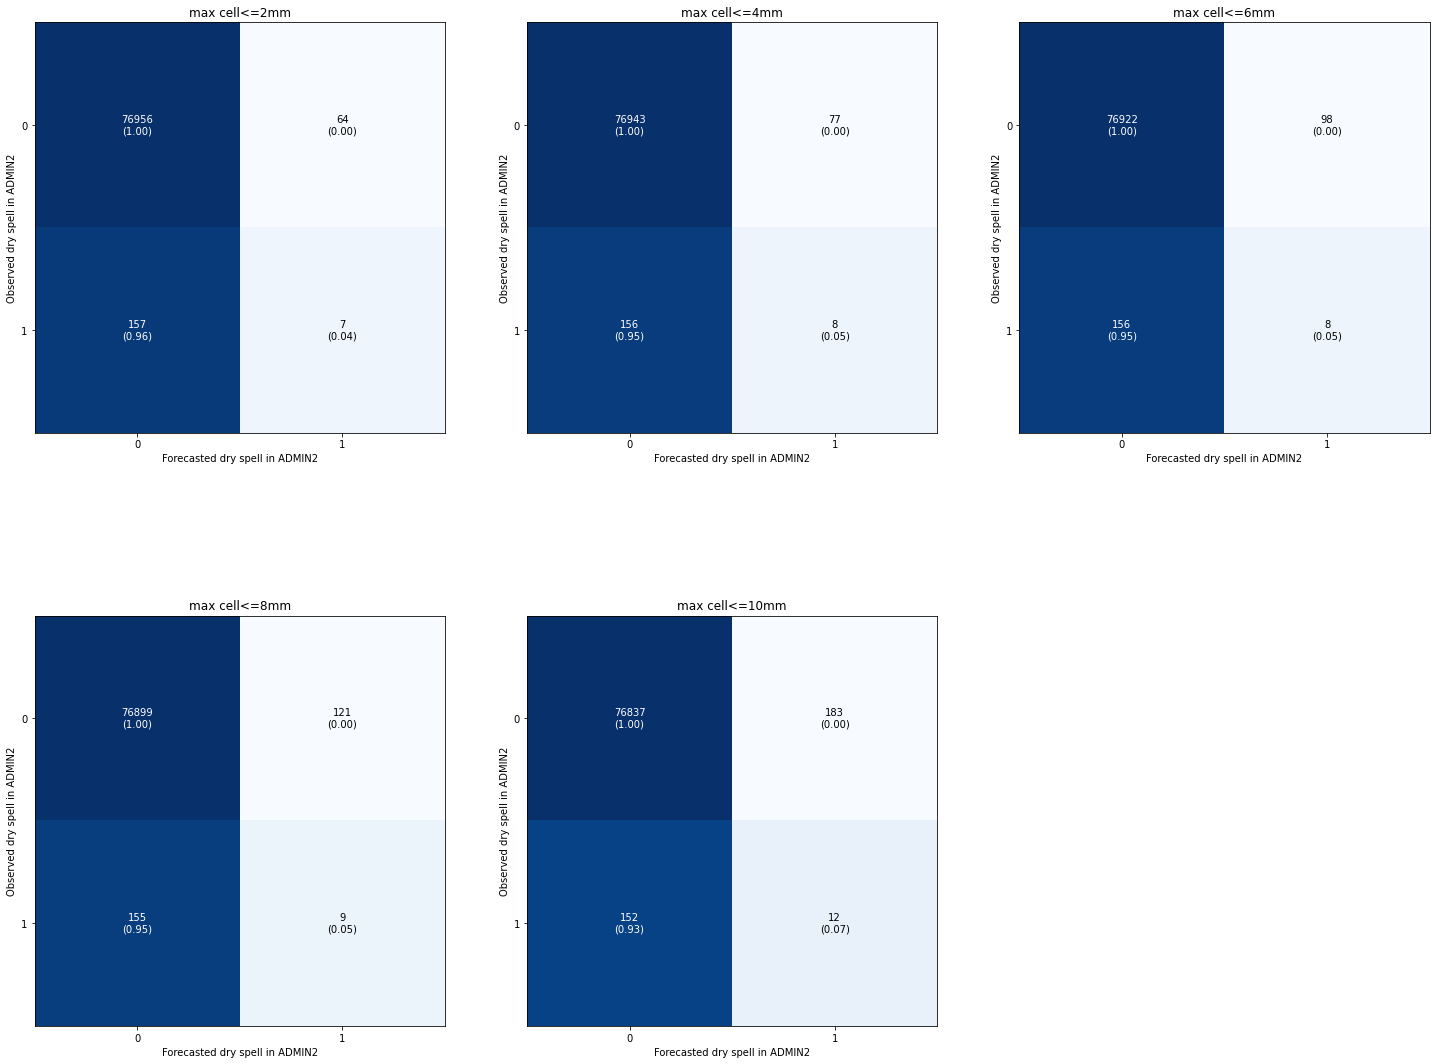

In [135]:
#compute the contigency table when using mean cell for different thresholds
t_list=[2,4,6,8,10]
num_plots = len(t_list)
colp_num=3
if num_plots==1:
    colp_num=1
rows = math.ceil(num_plots / colp_num)
position = range(1, num_plots + 1)
fig=plt.figure(figsize=(25,20))
for i,t in enumerate(t_list):
    y_target =    df_roll["dryspell_obs"]
    y_predicted = np.where(df_roll["max_cell"]<=t,1,0)
    ax = fig.add_subplot(rows,colp_num,i+1)
    cm = confusion_matrix(y_target=y_target, 
                          y_predicted=y_predicted)

    plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True,axis=ax) #,class_names=["No","Yes"])
    ax.set_ylabel("Observed dry spell in ADMIN2")
    ax.set_xlabel("Forecasted dry spell in ADMIN2")
    ax.set_title(f"max cell<={t}mm")

In [136]:
df_roll["dryspell_forec"]=np.where(df_roll.mean_cell<=2,1,0)

Text(0.5, 1.0, 'Observed and forecasted dryspells')

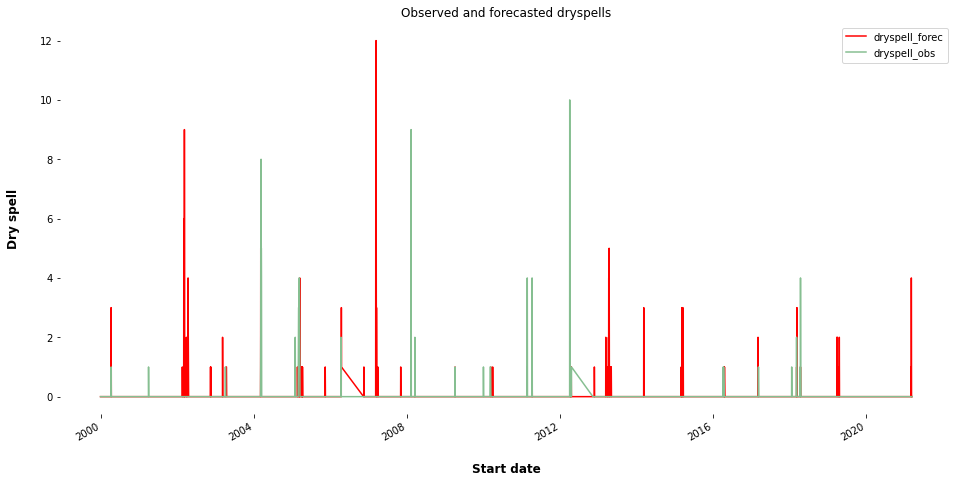

In [137]:
#number of adm2s with dryspell for forecasted and observed over time
#the diagonal lines are caused by the last day of a rainy season having a forecasted dry spell
from matplotlib.ticker import StrMethodFormatter
fig,ax=plt.subplots()
df_roll_date=df_roll.groupby("dateforec",as_index=False).sum()
df_roll_date.sort_values(by="dateforec").plot(x="dateforec",y="dryspell_forec" ,figsize=(16, 8), color='red',legend=True,ax=ax)
df_roll_date.sort_values(by="dateforec").plot(x="dateforec",y="dryspell_obs" ,figsize=(16, 8), color='#86bf91',legend=True,ax=ax)

# Set x-axis label
ax.set_xlabel("Start date", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("Dry spell", labelpad=20, weight='bold', size=12)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.title(f"Observed and forecasted dryspells")

### Overlap dry spells observed and forecasted

In [138]:
df_ds

,pcode,ADM2_EN,season_approx,dry_spell_first_date,dry_spell_last_date,dry_spell_duration,dry_spell_rainfall,region,year,dry_spell_extension
0,MW203,Ntchisi,2004,2005-03-08,2005-03-26,19,1.2,Central,2005,5
1,MW205,Salima,2004,2005-03-02,2005-03-26,25,1.6,Central,2005,11
2,MW209,Ntcheu,2004,2005-03-02,2005-03-25,24,1.7,Central,2005,10
3,MW302,Machinga,2004,2005-01-31,2005-02-13,14,1.0,Southern,2005,0
4,MW304,Chiradzulu,2007,2008-02-10,2008-02-24,15,0.0,Southern,2008,1
5,MW304,Chiradzulu,2009,2010-01-01,2010-01-14,14,1.0,Southern,2010,0
6,MW304,Chiradzulu,2019,2020-02-26,2020-03-10,14,0.3,Southern,2020,0
7,MW305,Blantyre,2007,2008-02-10,2008-02-24,15,0.1,Southern,2008,1
8,MW305,Blantyre,2009,2010-01-01,2010-01-14,14,1.7,Southern,2010,0
9,MW305,Blantyre,2019,2020-02-26,2020-03-10,14,1.7,Southern,2020,0


In [139]:
# #HACK
# df_ds=df_ds[df_ds.dry_spell_first_date.dt.month.isin([10,11,12,1,2])]

In [140]:
#create df with all dates that were part of a dry spell per adm2
# #only including data since 2010 since this is the chirps data we are currently using
# df_ds_2010=df_ds[df_ds.dry_spell_first_date.dt.year>=2010].sort_values(["ADM2_EN","dry_spell_first_date"]).reset_index(drop=True)
#assign an ID to each dry spell, such that we can group by that later on
df_ds["ID_obs"]=range(1,len(df_ds)+1)
#create datetimeindex per row
a = [pd.date_range(*r, freq='D') for r in df_ds[['dry_spell_first_date', 'dry_spell_last_date']].values]
#join the daterange with the adm2, which create a column per date, then stack to have each adm2-date combination
df_ds_daterange=df_ds[["ADM2_EN","ID_obs"]].join(pd.DataFrame(a)).set_index(["ADM2_EN","ID_obs"]).stack().droplevel(-1).reset_index()
df_ds_daterange.rename(columns={0:"date"},inplace=True)
#all dates in this dataframe had an observed dry spell
df_ds_daterange["dryspell_obs"]=1

In [141]:
df_ds.sort_values("dry_spell_first_date")

,pcode,ADM2_EN,season_approx,dry_spell_first_date,dry_spell_last_date,dry_spell_duration,dry_spell_rainfall,region,year,dry_spell_extension,ID_obs
29,MW311,Nsanje,2001,2002-02-20,2002-03-05,14,1.3,Southern,2002,0,30
30,MW311,Nsanje,2003,2004-03-10,2004-03-25,16,0.7,Southern,2004,2,31
36,MW313,Neno,2004,2005-01-30,2005-02-14,16,2.7,Southern,2005,2,37
10,MW306,Mwanza,2004,2005-01-30,2005-02-14,16,1.0,Southern,2005,2,11
3,MW302,Machinga,2004,2005-01-31,2005-02-13,14,1.0,Southern,2005,0,4
31,MW311,Nsanje,2004,2005-01-31,2005-02-13,14,1.3,Southern,2005,0,32
23,MW310,Chikwawa,2004,2005-01-31,2005-02-13,14,0.5,Southern,2005,0,24
39,MW314,Zomba City,2004,2005-03-01,2005-03-26,26,0.0,Southern,2005,12,40
1,MW205,Salima,2004,2005-03-02,2005-03-26,25,1.6,Central,2005,11,2
2,MW209,Ntcheu,2004,2005-03-02,2005-03-25,24,1.7,Central,2005,10,3


In [142]:
df_ds.groupby("year").count()

,pcode,ADM2_EN,season_approx,dry_spell_first_date,dry_spell_last_date,dry_spell_duration,dry_spell_rainfall,region,dry_spell_extension,ID_obs
year,,,,,,,,,,
2002,1,1,1,1,1,1,1,1,1,1
2004,1,1,1,1,1,1,1,1,1,1
2005,9,9,9,9,9,9,9,9,9,9
2008,10,10,10,10,10,10,10,10,10,10
2009,1,1,1,1,1,1,1,1,1,1
2010,5,5,5,5,5,5,5,5,5,5
2011,6,6,6,6,6,6,6,6,6,6
2017,3,3,3,3,3,3,3,3,3,3
2018,3,3,3,3,3,3,3,3,3,3


In [143]:
df_ds[df_ds.ADM2_EN=="Blantyre City"]

,pcode,ADM2_EN,season_approx,dry_spell_first_date,dry_spell_last_date,dry_spell_duration,dry_spell_rainfall,region,year,dry_spell_extension,ID_obs
42,MW315,Blantyre City,2007,2008-02-10,2008-02-24,15,0.0,Southern,2008,1,43
43,MW315,Blantyre City,2016,2017-03-06,2017-03-19,14,0.0,Southern,2017,0,44
44,MW315,Blantyre City,2019,2020-02-26,2020-03-11,15,0.0,Southern,2020,1,45


In [144]:
df_ds_daterange[df_ds_daterange.ID_obs==5]

,ADM2_EN,ID_obs,date,dryspell_obs
82,Chiradzulu,5,2008-02-10,1
83,Chiradzulu,5,2008-02-11,1
84,Chiradzulu,5,2008-02-12,1
85,Chiradzulu,5,2008-02-13,1
86,Chiradzulu,5,2008-02-14,1
87,Chiradzulu,5,2008-02-15,1
88,Chiradzulu,5,2008-02-16,1
89,Chiradzulu,5,2008-02-17,1
90,Chiradzulu,5,2008-02-18,1
91,Chiradzulu,5,2008-02-19,1


In [145]:
len(df_ds_daterange)

704

In [146]:
df_ds_daterange=df_ds_daterange.drop_duplicates()

In [147]:
#there shouldn't be any duplicates so check if two lengths match
len(df_ds_daterange)

704

In [148]:
#select all dates where chirps-gefs forecasts dry spell
df_cg_ds=df_chirpsgefs[df_chirpsgefs.mean_cell<=2]

In [149]:
# #HACK
# df_cg_ds=df_cg_ds[df_cg_ds.date.dt.month.isin([10,11,12,1,2])]

In [150]:
df_cg_ds

,Shape_Leng,Shape_Area,ADM2_EN,ADM2_PCODE,ADM2_REF,ADM2ALT1EN,ADM2ALT2EN,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,max_cell,min_cell,mean_cell,perc_se2,perc_se10,date_forec_end
334,2.036817,0.179379,Balaka,MW312,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2002-03-11,2018-10-16,NaN,7.533781,0.0,0.582076,90.410959,100.0,2002-03-25
548,2.036817,0.179379,Balaka,MW312,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2004-03-08,2018-10-16,NaN,7.169666,0.0,1.727827,63.013699,100.0,2004-03-22
896,2.036817,0.179379,Balaka,MW312,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2007-03-10,2018-10-16,NaN,7.950090,0.0,0.613398,90.410959,100.0,2007-03-24
899,2.036817,0.179379,Balaka,MW312,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2007-03-13,2018-10-16,NaN,8.954193,0.0,0.351268,93.150685,100.0,2007-03-27
2015,2.036817,0.179379,Balaka,MW312,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2018-03-09,2018-10-16,NaN,8.504754,0.0,1.994553,64.383562,100.0,2018-03-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76751,0.295003,0.003375,Zomba City,MW314,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2017-03-03,2018-10-16,NaN,0.000000,0.0,0.000000,100.000000,100.0,2017-03-17
76752,0.295003,0.003375,Zomba City,MW314,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2017-03-04,2018-10-16,NaN,0.000000,0.0,0.000000,100.000000,100.0,2017-03-18
76889,0.295003,0.003375,Zomba City,MW314,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2018-03-06,2018-10-16,NaN,0.000000,0.0,0.000000,100.000000,100.0,2018-03-20
76892,0.295003,0.003375,Zomba City,MW314,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2018-03-09,2018-10-16,NaN,0.000000,0.0,0.000000,100.000000,100.0,2018-03-23


In [151]:
# df_cg_ds.sort_values("date").groupby("ADM2_EN").date.diff().dt.days.ne(1).cumsum()

In [152]:
#create list of dates that were within a forecast that predicted a dry spell
df_cg_ds=df_cg_ds.sort_values(["ADM2_EN","date"]).reset_index(drop=True)
a = [pd.date_range(*r, freq='D') for r in df_cg_ds[['date', 'date_forec_end']].values]
df_cg_daterange=df_cg_ds[["ADM2_EN"]].join(pd.DataFrame(a)).set_index(["ADM2_EN"]).stack().droplevel(-1).reset_index()
df_cg_daterange.rename(columns={0:"date"},inplace=True)
df_cg_daterange["dryspell_forec"]=1

In [153]:
df_cg_daterange

,ADM2_EN,date,dryspell_forec
0,Balaka,2002-03-11,1
1,Balaka,2002-03-12,1
2,Balaka,2002-03-13,1
3,Balaka,2002-03-14,1
4,Balaka,2002-03-15,1
...,...,...,...
3010,Zomba City,2021-03-11,1
3011,Zomba City,2021-03-12,1
3012,Zomba City,2021-03-13,1
3013,Zomba City,2021-03-14,1


In [154]:
len(df_cg_daterange)

3015

In [155]:
#with the forecast it is expected to be a lot of overlap
df_cg_daterange=df_cg_daterange.drop_duplicates()

In [156]:
#still many more dates forecasted to be part of a dry spell than the observed..
len(df_cg_daterange)

1772

In [157]:
len(df_ds_daterange)

704

In [158]:
#assign ID to each forecasted dry spell
#we assign one ID per any overlapping range
#e.g. if dry spell forecasted on 01-01 and 03-01 (but not 02-01), we would see this as one dry spell from 01-01 till 17-01
df_cg_daterange["ID_forec"]=df_cg_daterange.sort_values(["ADM2_EN","date"]).groupby("ADM2_EN").date.diff().dt.days.ne(1).cumsum()

<ipython-input-158-3671ce108d6c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cg_daterange["ID_forec"]=df_cg_daterange.sort_values(["ADM2_EN","date"]).groupby("ADM2_EN").date.diff().dt.days.ne(1).cumsum()


In [159]:
#create dataframe with all dates, where for each date it is added whether a dry spell was observed and/or forecasted
#include all dates for which we got chirpsgefs data
df_dates=df_chirpsgefs[["date","ADM2_EN"]].sort_values(["ADM2_EN","date"])

In [160]:
#merge the observed dry spells
#merge on left, such to only include dates for which a forecast is available
df_dates=df_dates.merge(df_ds_daterange,how="left",on=["date","ADM2_EN"])
df_dates.dryspell_obs=df_dates.dryspell_obs.replace(np.nan,0)

In [161]:
len(df_ds_daterange[(df_ds_daterange.date.dt.year==2020)])#&(df_dates.dryspell_obs==1)]

87

In [162]:
#AAHH lots of obs dryspell dates went missing...
#largest part (87) also because of chirps-gefs data missing 2020
len(df_dates[df_dates.dryspell_obs==1])

596

In [163]:
len(df_ds_daterange)-len(df_dates[df_dates.dryspell_obs==1])

108

In [164]:
# common = df_ds_daterange.merge(df_dates,on=['date','ADM2_EN'])
# print(common)
# df_ds_daterange[(~df_ds_daterange.date.isin(common.date))&(~df_ds_daterange.ADM2_EN.isin(common.ADM2_EN))]

In [165]:
# df_ds_daterange[["date","ADM2_EN"]].isin(df_dates[["date","ADM2_EN"]])

In [166]:
# df_ds_daterange[["date","ADM2_EN"]][~df_ds_daterange[["date","ADM2_EN"]].isin(df_dates[["date","ADM2_EN"]])].dropna(how="any")

In [167]:
#merge the forecasted dry spells
df_dates=df_dates.merge(df_cg_daterange,how="left",on=["date","ADM2_EN"])
df_dates.dryspell_forec=df_dates.dryspell_forec.replace(np.nan,0)

In [168]:
df_dates

,date,ADM2_EN,ID_obs,dryspell_obs,dryspell_forec,ID_forec
0,2000-01-01,Balaka,NaN,0.0,0.0,NaN
1,2000-01-02,Balaka,NaN,0.0,0.0,NaN
2,2000-01-03,Balaka,NaN,0.0,0.0,NaN
3,2000-01-04,Balaka,NaN,0.0,0.0,NaN
4,2000-01-05,Balaka,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...
77191,2021-03-08,Zomba City,NaN,0.0,1.0,103.0
77192,2021-03-09,Zomba City,NaN,0.0,1.0,103.0
77193,2021-03-10,Zomba City,NaN,0.0,1.0,103.0
77194,2021-03-11,Zomba City,NaN,0.0,1.0,103.0


In [169]:
# df_dates=df_dates[df_dates.date.dt.month.isin([10,11,12,1,2])]

In [170]:
# df_dates[df_dates.dryspell_obs.isnull()]

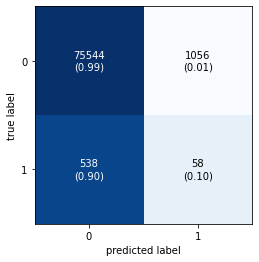

In [171]:
y_target =    df_dates["dryspell_obs"]
y_predicted = df_dates["dryspell_forec"]

cm = confusion_matrix(y_target=y_target, 
                      y_predicted=y_predicted)

fig, ax = plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True) #,class_names=["No","Yes"])
# ax.set_ylabel("Day within observed dry spell")
# ax.set_xlabel("Day within forecasted dry spell")
plt.show()

In [172]:
#some complete dry spells went missing --> is because of 2020 missing data..
df_dates.sort_values("ID_obs").ID_obs.unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  8.,  9., 11., 12., 13., 14., 16.,
       17., 18., 19., 20., 21., 23., 24., 25., 26., 27., 28., 30., 31.,
       32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43., 44.,
       nan])

In [173]:
# df_ds_2010[df_ds_2010.ID_obs.isin([4,6,11,14,36,40])]

In [174]:
df_dates[df_dates.ID_obs==43]

,date,ADM2_EN,ID_obs,dryspell_obs,dryspell_forec,ID_forec
5636,2008-02-10,Blantyre City,43.0,1.0,0.0,NaN
5637,2008-02-11,Blantyre City,43.0,1.0,0.0,NaN
5638,2008-02-12,Blantyre City,43.0,1.0,0.0,NaN
5639,2008-02-13,Blantyre City,43.0,1.0,0.0,NaN
5640,2008-02-14,Blantyre City,43.0,1.0,0.0,NaN
5641,2008-02-15,Blantyre City,43.0,1.0,0.0,NaN
5642,2008-02-16,Blantyre City,43.0,1.0,0.0,NaN
5643,2008-02-17,Blantyre City,43.0,1.0,0.0,NaN
5644,2008-02-18,Blantyre City,43.0,1.0,0.0,NaN
5645,2008-02-19,Blantyre City,43.0,1.0,0.0,NaN


In [175]:
# df_dates.groupby("ID_obs").dryspell_forec.apply(lambda x: np.argmax(x.values))#.ID_forec.first_valid_index()

In [176]:
# df_dates[df_dates.ID_obs==1].ID_forec.first_valid_index()#s.index.get_loc(s.first_valid_index())

In [177]:
df_forec_dates=df_dates.groupby("ID_forec",as_index=False).agg(start_date=("date","min"),end_date=("date","max"))

In [178]:
df_forec_dates

,ID_forec,start_date,end_date
0,1.0,2002-03-11,2002-03-23
1,2.0,2004-03-08,2004-03-15
2,3.0,2007-03-10,2007-03-26
3,4.0,2018-03-09,2018-03-15
4,5.0,2002-03-11,2002-03-23
...,...,...,...
98,99.0,2014-03-09,2014-03-19
99,100.0,2015-03-01,2015-03-22
100,101.0,2017-03-03,2017-03-18
101,102.0,2018-03-06,2018-03-23


In [179]:
df_obs_dates=df_dates.groupby("ID_obs",as_index=False).agg(start_date=("date","min"),end_date=("date","max"))

In [180]:
df_dsobsgr=df_dates.groupby("ID_obs").sum()

In [181]:
df_dsobsgr

,dryspell_obs,dryspell_forec,ID_forec
ID_obs,,,
1.0,19.0,0.0,0.0
2.0,14.0,0.0,0.0
3.0,14.0,0.0,0.0
4.0,14.0,0.0,0.0
5.0,15.0,0.0,0.0
6.0,14.0,0.0,0.0
8.0,15.0,0.0,0.0
9.0,14.0,0.0,0.0
11.0,16.0,0.0,0.0


In [182]:
df_dsobsgr=df_dsobsgr.drop("ID_forec",axis=1)

In [183]:
df_dsobsgr["ID_forec"]=df_dates.groupby("ID_obs").ID_forec.apply(lambda x: x.min(skipna=True))

In [184]:
df_dsobsgr

,dryspell_obs,dryspell_forec,ID_forec
ID_obs,,,
1.0,19.0,0.0,NaN
2.0,14.0,0.0,NaN
3.0,14.0,0.0,NaN
4.0,14.0,0.0,NaN
5.0,15.0,0.0,NaN
6.0,14.0,0.0,NaN
8.0,15.0,0.0,NaN
9.0,14.0,0.0,NaN
11.0,16.0,0.0,NaN


In [185]:
df_obsid=df_dsobsgr.reset_index().merge(df_forec_dates[["ID_forec","start_date"]],how="left",on="ID_forec").rename(columns={"start_date":"start_date_forec"})

In [186]:
# df_obsid=df_obsid.merge(df_forec_dates[["ID_forec","start_date"]],how="left",on="ID_forec").rename(columns={"start_date":"start_date_forec"})

In [187]:
df_obsid

,ID_obs,dryspell_obs,dryspell_forec,ID_forec,start_date_forec
0,1.0,19.0,0.0,NaN,NaT
1,2.0,14.0,0.0,NaN,NaT
2,3.0,14.0,0.0,NaN,NaT
3,4.0,14.0,0.0,NaN,NaT
4,5.0,15.0,0.0,NaN,NaT
5,6.0,14.0,0.0,NaN,NaT
6,8.0,15.0,0.0,NaN,NaT
7,9.0,14.0,0.0,NaN,NaT
8,11.0,16.0,0.0,NaN,NaT
9,12.0,15.0,0.0,NaN,NaT


In [188]:
df_obsid=df_obsid.merge(df_obs_dates[["ID_obs","start_date"]],how="left",on="ID_obs").rename(columns={"start_date":"start_date_obs"})

In [189]:
df_obsid

,ID_obs,dryspell_obs,dryspell_forec,ID_forec,start_date_forec,start_date_obs
0,1.0,19.0,0.0,NaN,NaT,2005-03-08
1,2.0,14.0,0.0,NaN,NaT,2005-03-02
2,3.0,14.0,0.0,NaN,NaT,2005-03-02
3,4.0,14.0,0.0,NaN,NaT,2005-01-31
4,5.0,15.0,0.0,NaN,NaT,2008-02-10
5,6.0,14.0,0.0,NaN,NaT,2010-01-01
6,8.0,15.0,0.0,NaN,NaT,2008-02-10
7,9.0,14.0,0.0,NaN,NaT,2010-01-01
8,11.0,16.0,0.0,NaN,NaT,2005-01-30
9,12.0,15.0,0.0,NaN,NaT,2008-02-10


In [190]:
df_obsid[df_obsid.ID_obs==43]

,ID_obs,dryspell_obs,dryspell_forec,ID_forec,start_date_forec,start_date_obs
37,43.0,15.0,0.0,NaN,NaT,2008-02-10


In [191]:
df_obsid["days_late"]=(df_obsid.start_date_forec-df_obsid.start_date_obs).dt.days

In [192]:
df_obsid[df_obsid.days_late<0]

,ID_obs,dryspell_obs,dryspell_forec,ID_forec,start_date_forec,start_date_obs,days_late
24,30.0,14.0,14.0,55.0,2002-02-19,2002-02-20,-1.0
35,41.0,15.0,12.0,101.0,2017-03-03,2017-03-07,-4.0


In [193]:
df_obsid[df_obsid.start_date_obs.dt.month.isin([10,11,12,1,2])]

,ID_obs,dryspell_obs,dryspell_forec,ID_forec,start_date_forec,start_date_obs,days_late
3,4.0,14.0,0.0,NaN,NaT,2005-01-31,NaN
4,5.0,15.0,0.0,NaN,NaT,2008-02-10,NaN
5,6.0,14.0,0.0,NaN,NaT,2010-01-01,NaN
6,8.0,15.0,0.0,NaN,NaT,2008-02-10,NaN
7,9.0,14.0,0.0,NaN,NaT,2010-01-01,NaN
8,11.0,16.0,0.0,NaN,NaT,2005-01-30,NaN
9,12.0,15.0,0.0,NaN,NaT,2008-02-10,NaN
10,13.0,14.0,0.0,NaN,NaT,2010-01-01,NaN
11,14.0,16.0,0.0,NaN,NaT,2011-02-21,NaN
12,16.0,15.0,0.0,NaN,NaT,2008-02-10,NaN


In [194]:
df_obsid[df_obsid.ID_forec.isnull()]

,ID_obs,dryspell_obs,dryspell_forec,ID_forec,start_date_forec,start_date_obs,days_late
0,1.0,19.0,0.0,NaN,NaT,2005-03-08,NaN
1,2.0,14.0,0.0,NaN,NaT,2005-03-02,NaN
2,3.0,14.0,0.0,NaN,NaT,2005-03-02,NaN
3,4.0,14.0,0.0,NaN,NaT,2005-01-31,NaN
4,5.0,15.0,0.0,NaN,NaT,2008-02-10,NaN
5,6.0,14.0,0.0,NaN,NaT,2010-01-01,NaN
6,8.0,15.0,0.0,NaN,NaT,2008-02-10,NaN
7,9.0,14.0,0.0,NaN,NaT,2010-01-01,NaN
8,11.0,16.0,0.0,NaN,NaT,2005-01-30,NaN
9,12.0,15.0,0.0,NaN,NaT,2008-02-10,NaN


In [195]:
df_obsid[df_obsid.ID_obs==55]

,ID_obs,dryspell_obs,dryspell_forec,ID_forec,start_date_forec,start_date_obs,days_late


<AxesSubplot:xlabel='days_late', ylabel='Count'>

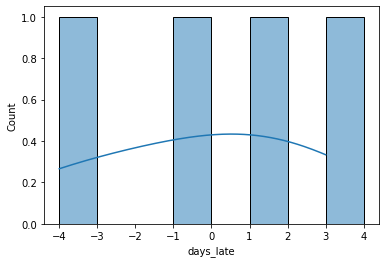

In [196]:
sns.histplot(df_obsid[df_obsid.dryspell_forec>0],bins=np.arange(df_obsid.days_late.min(),df_obsid.days_late.max()+2),x="days_late",stat="count",kde=True)

In [197]:
# #-1 indicates no overlap
# df_obsid["days_late"]=df_dates.groupby("ID_obs").ID_forec.apply(lambda x: x.argmax(skipna=True))#.ID_forec.first_valid_index()
# df_obsid["days_late"]=df_obsid["days_late"].replace(-1,np.nan)

In [198]:
round(len(df_obsid[df_obsid.dryspell_forec>0])/len(df_obsid)*100,2)

10.26

<AxesSubplot:xlabel='dryspell_forec', ylabel='Count'>

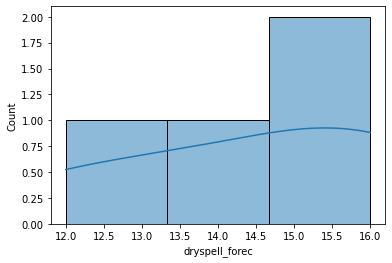

In [199]:
sns.histplot(df_obsid[df_obsid.dryspell_forec>0],x="dryspell_forec",stat="count",kde=True)

In [200]:
df_dsforgr=df_dates.groupby("ID_forec").sum()
df_dsforgr=df_dsforgr.drop("ID_obs",axis=1)

In [201]:
df_dsforgr

,dryspell_obs,dryspell_forec
ID_forec,,
1.0,0.0,13.0
2.0,0.0,8.0
3.0,0.0,17.0
4.0,0.0,7.0
5.0,0.0,13.0
...,...,...
99.0,0.0,11.0
100.0,0.0,22.0
101.0,12.0,16.0


In [202]:
df_dsforgr["ID_obs"]=df_dates.groupby("ID_forec").ID_obs.apply(lambda x: x.min(skipna=True))

In [203]:
df_dsforgr

,dryspell_obs,dryspell_forec,ID_obs
ID_forec,,,
1.0,0.0,13.0,NaN
2.0,0.0,8.0,NaN
3.0,0.0,17.0,NaN
4.0,0.0,7.0,NaN
5.0,0.0,13.0,NaN
...,...,...,...
99.0,0.0,11.0,NaN
100.0,0.0,22.0,NaN
101.0,12.0,16.0,41.0


In [204]:
df_forid=df_dsforgr.reset_index().merge(df_obs_dates[["ID_obs","start_date"]],how="left",on="ID_obs").rename(columns={"start_date":"start_date_obs"})

In [205]:
df_forid

,ID_forec,dryspell_obs,dryspell_forec,ID_obs,start_date_obs
0,1.0,0.0,13.0,NaN,NaT
1,2.0,0.0,8.0,NaN,NaT
2,3.0,0.0,17.0,NaN,NaT
3,4.0,0.0,7.0,NaN,NaT
4,5.0,0.0,13.0,NaN,NaT
...,...,...,...,...,...
98,99.0,0.0,11.0,NaN,NaT
99,100.0,0.0,22.0,NaN,NaT
100,101.0,12.0,16.0,41.0,2017-03-07
101,102.0,16.0,18.0,42.0,2018-03-03


In [206]:
df_forid=df_forid.merge(df_forec_dates[["ID_forec","start_date"]],how="left",on="ID_forec").rename(columns={"start_date":"start_date_forec"})

In [207]:
df_forid

,ID_forec,dryspell_obs,dryspell_forec,ID_obs,start_date_obs,start_date_forec
0,1.0,0.0,13.0,NaN,NaT,2002-03-11
1,2.0,0.0,8.0,NaN,NaT,2004-03-08
2,3.0,0.0,17.0,NaN,NaT,2007-03-10
3,4.0,0.0,7.0,NaN,NaT,2018-03-09
4,5.0,0.0,13.0,NaN,NaT,2002-03-11
...,...,...,...,...,...,...
98,99.0,0.0,11.0,NaN,NaT,2014-03-09
99,100.0,0.0,22.0,NaN,NaT,2015-03-01
100,101.0,12.0,16.0,41.0,2017-03-07,2017-03-03
101,102.0,16.0,18.0,42.0,2018-03-03,2018-03-06


In [208]:
df_forid[df_forid.ID_obs==43]

,ID_forec,dryspell_obs,dryspell_forec,ID_obs,start_date_obs,start_date_forec


In [209]:
df_forid["days_late"]=(df_forid.start_date_obs-df_forid.start_date_forec).dt.days

In [210]:
round(len(df_forid[df_forid.dryspell_obs>0])/len(df_forid)*100,2)

3.88

In [211]:
df_forid["start_month_forec"]=df_forid.start_date_forec.dt.month

<AxesSubplot:xlabel='start_month_forec', ylabel='Count'>

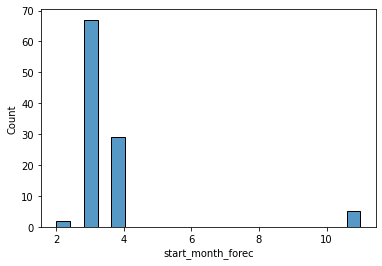

In [212]:
sns.histplot(df_forid,x="start_month_forec")

<AxesSubplot:xlabel='start_month_forec', ylabel='Count'>

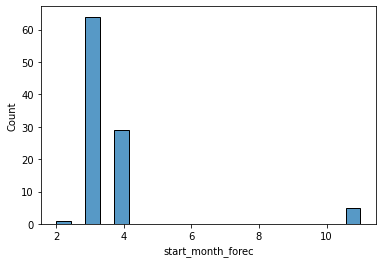

In [213]:
sns.histplot(df_forid[df_forid.dryspell_obs==0],x="start_month_forec")

Text(0.5, 1.0, 'Observed and forecasted dryspells')

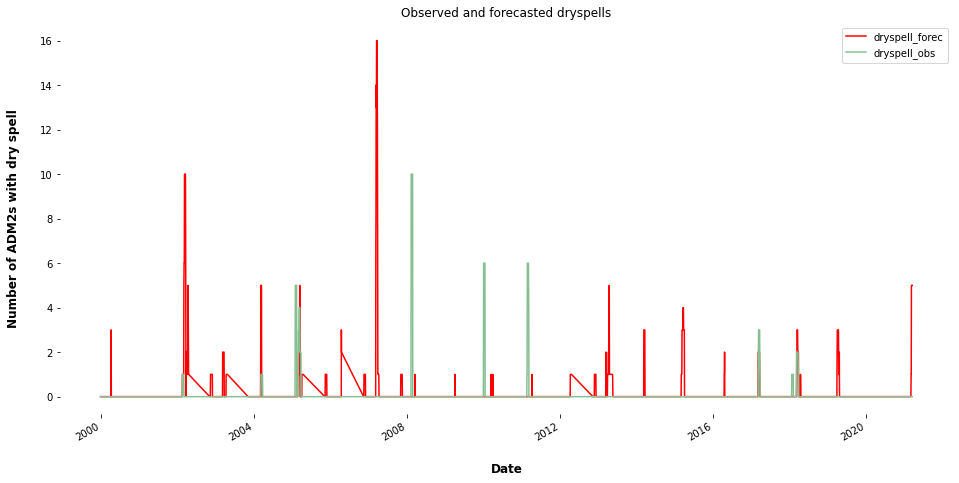

In [214]:
#number of adm2s with dryspell for forecasted and observed over time
#the diagonal lines are caused by the last day of a rainy season having a forecasted dry spell
from matplotlib.ticker import StrMethodFormatter
fig,ax=plt.subplots()
df_dates_group=df_dates.groupby("date",as_index=False).sum()
df_dates_group.sort_values(by="date").plot(x="date",y="dryspell_forec" ,figsize=(16, 8), color='red',legend=True,ax=ax)
df_dates_group.sort_values(by="date").plot(x="date",y="dryspell_obs" ,figsize=(16, 8), color='#86bf91',legend=True,ax=ax)

# Set x-axis label
ax.set_xlabel("Date", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("Number of ADM2s with dry spell", labelpad=20, weight='bold', size=12)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.title(f"Observed and forecasted dryspells")

In [215]:
df_ds.sort_values(["ADM2_EN","dry_spell_first_date"])

,pcode,ADM2_EN,season_approx,dry_spell_first_date,dry_spell_last_date,dry_spell_duration,dry_spell_rainfall,region,year,dry_spell_extension,ID_obs
35,MW312,Balaka,2007,2008-02-10,2008-02-24,15,1.6,Southern,2008,1,36
7,MW305,Blantyre,2007,2008-02-10,2008-02-24,15,0.1,Southern,2008,1,8
8,MW305,Blantyre,2009,2010-01-01,2010-01-14,14,1.7,Southern,2010,0,9
9,MW305,Blantyre,2019,2020-02-26,2020-03-10,14,1.7,Southern,2020,0,10
42,MW315,Blantyre City,2007,2008-02-10,2008-02-24,15,0.0,Southern,2008,1,43
43,MW315,Blantyre City,2016,2017-03-06,2017-03-19,14,0.0,Southern,2017,0,44
44,MW315,Blantyre City,2019,2020-02-26,2020-03-11,15,0.0,Southern,2020,1,45
23,MW310,Chikwawa,2004,2005-01-31,2005-02-13,14,0.5,Southern,2005,0,24
24,MW310,Chikwawa,2007,2008-02-11,2008-02-24,14,1.8,Southern,2008,0,25
25,MW310,Chikwawa,2009,2009-12-31,2010-01-14,15,1.9,Southern,2009,1,26


In [216]:
df_ds_mul=df_ds[df_ds.ADM2_EN=="Mulanje"].reset_index()

In [217]:
df_ds_mul

,index,pcode,ADM2_EN,season_approx,dry_spell_first_date,dry_spell_last_date,dry_spell_duration,dry_spell_rainfall,region,year,dry_spell_extension,ID_obs
0,18,MW308,Mulanje,2007,2008-02-10,2008-02-24,15,0.0,Southern,2008,1,19
1,19,MW308,Mulanje,2009,2010-01-01,2010-01-14,14,1.9,Southern,2010,0,20
2,20,MW308,Mulanje,2010,2011-02-22,2011-03-07,14,0.2,Southern,2011,0,21
3,21,MW308,Mulanje,2019,2020-02-26,2020-03-10,14,1.0,Southern,2020,0,22


2008-02-10 00:00:00
2010-01-01 00:00:00
2011-02-22 00:00:00
2020-02-26 00:00:00


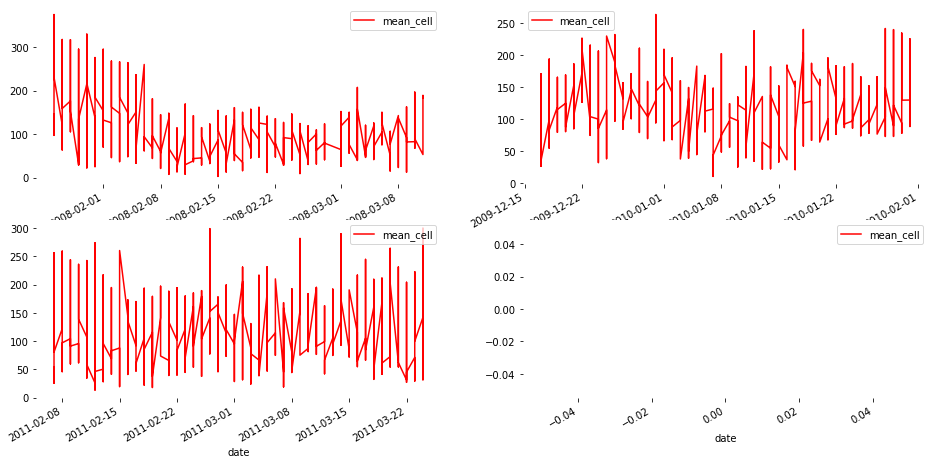

In [218]:
num_plots = len(df_ds_mul)
colp_num=2
if num_plots==1:
    colp_num=1
rows = math.ceil(num_plots / colp_num)
position = range(1, num_plots + 1)
fig=plt.figure(figsize=(30,20))
for index, row in df_ds_mul.iterrows():
    #assuming index is range 0..len(df)
#     print(index)
    ax = fig.add_subplot(rows,colp_num,index+1)
    df_chirpsgefs_sel=df_chirpsgefs[(df_chirpsgefs.date>=row.dry_spell_first_date-timedelta(days=15))&(df_chirpsgefs.date<=row.dry_spell_first_date+timedelta(days=30))]
    print(row.dry_spell_first_date)
    df_chirpsgefs_sel.sort_values(by="date").plot(x="date",y="mean_cell",figsize=(16, 8), color='red',legend=True,ax=ax)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

Text(0.5, 1.0, 'Forecasted rainfall Mulanje 2010')

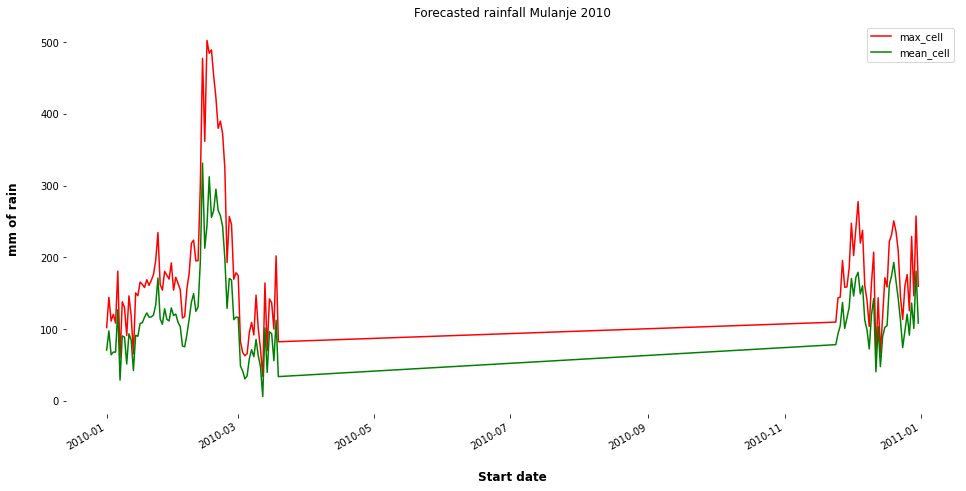

In [219]:
#inspect difference min and max cell touched
#plot data of Balaka for 2011
fig,ax=plt.subplots()
df_comb[(df_comb.date.dt.year==2010)&(df_comb.ADM2_EN=="Mulanje")].sort_values(by="date").plot(x="date",y="max_cell" ,figsize=(16, 8), color='red',legend=True,ax=ax)
df_comb[(df_comb.date.dt.year==2010)&(df_comb.ADM2_EN=="Mulanje")].sort_values(by="date").plot(x="date",y="mean_cell" ,figsize=(16, 8), color='green',legend=True,ax=ax)

# Set x-axis label
ax.set_xlabel("Start date", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("mm of rain", labelpad=20, weight='bold', size=12)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.title(f"Forecasted rainfall Mulanje 2010")

In [152]:
# #path to data start and end rainy season
# df_rain=pd.read_csv(os.path.join(country_data_processed_dir,"dry_spells","rainy_seasons_detail_2000_2020_mean.csv"))
# df_rain["onset_date"]=pd.to_datetime(df_rain["onset_date"])
# df_rain["cessation_date"]=pd.to_datetime(df_rain["cessation_date"])
# #set the onset and cessation date for the seasons with them missing (meaning there was no dry spell data from start/till end of the season)
# df_rain_filled=df_rain.copy()
# df_rain_filled=df_rain_filled[(df_rain_filled.onset_date.notnull())|(df_rain_filled.cessation_date.notnull())]
# df_rain_filled[df_rain_filled.onset_date.isnull()]=df_rain_filled[df_rain_filled.onset_date.isnull()].assign(onset_date=lambda df: pd.to_datetime(f"{df.season_approx.values[0]}-11-01"))
# df_rain_filled[df_rain_filled.cessation_date.isnull()]=df_rain_filled[df_rain_filled.cessation_date.isnull()].assign(cessation_date=lambda df: pd.to_datetime(f"{df.season_approx.values[0]+1}-07-01"))
# #get min onset and max cessation for each season across all admin2's
# df_rain_seas=df_rain_filled.groupby("season_approx",as_index=False).agg({'onset_date': np.min,"cessation_date":np.max})
# all_dates=pd.Index([])
# for i in df_rain_seas.season_approx.unique():
#     seas_range=pd.date_range(df_rain_seas[df_rain_seas.season_approx==i].onset_date.values[0],df_rain_seas[df_rain_seas.season_approx==i].cessation_date.values[0])
#     all_dates=all_dates.union(seas_range)
# df_ds_daterange[~df_ds_daterange.date.isin(all_dates)]

In [ ]:
# dates = pd.DataFrame(pd.date_range(start=df_cg_ds.min().StartDate, 
#                      end=df_cg_ds.max().EndDate), columns=['Date'])
# pd.merge(left=dates, right=df, left_on='Date', right_on='StartDate', 
#          how='outer').fillna(method='ffill')

In [ ]:
# melt = df_ds[["ADM2_EN","dry_spell_first_date","dry_spell_last_date"]].melt(id_vars=['ADM2_EN'], value_name='date').drop('variable', axis=1)
# melt['date'] = pd.to_datetime(melt['date'])

# melt = melt.groupby('ADM2_EN').apply(lambda x: x.set_index('date').resample('d').first())\
#            .ffill()\
#            .reset_index(level=1)\
#            .reset_index(drop=True)

In [ ]:
# list_overlap=[]
# for a in df_ds.ADM2_EN.unique():
# #     dates_ds_adm2=pd.index([])
#     dates_adm2=pd.Index([])
#     df_adm2=df_cg_ds[df_cg_ds.ADM2_EN==a]
#     for i in df_adm2.date.unique():
#         df_adm2_date=df_adm2[df_adm2.date==i]
# #         print(df_adm2_date.dry_spell_first_date.values[0])
# #         print(df_adm2_date.dry_spell_last_date.values[0])
# #         forec_range=pd.period_range(df_adm2_date.dry_spell_first_date.values[0]-timedelta(days=13),df_adm2_date.dry_spell_last_date.values[0]-timedelta(days=1))
#         forec_range=pd.period_range(df_adm2_date.date.values[0],df_adm2_date.date_forec_end.values[0],freq="D")
#         dates_adm2=dates_adm2.union(forec_range)
# #     print(dates_adm2)
# #     print(df_chirpsgefs.date)
#     df_chirpsgefs["ds_range_forec"]
#     list_overlap.append(df_chirpsgefs[(df_chirpsgefs.ADM2_EN==a)&(df_chirpsgefs.date.isin(dates_adm2))])
# df_chirpsgefs_overlap=pd.concat(list_overlap)
# #         ds_range=pd.period_range(i["dry_spell_first_dat"])

In [ ]:
# list_overlap=[]
# for a in df_ds.ADM2_EN.unique():
# #     dates_ds_adm2=pd.index([])
#     dates_adm2=pd.Index([])
#     df_adm2=df_ds[df_ds.ADM2_EN==a]
#     for i in df_adm2.dry_spell_first_date.unique():
#         df_adm2_date=df_adm2[df_adm2.dry_spell_first_date==i]
#         print(df_adm2_date.dry_spell_first_date.values[0])
#         print(df_adm2_date.dry_spell_last_date.values[0])
# #         forec_range=pd.period_range(df_adm2_date.dry_spell_first_date.values[0]-timedelta(days=13),df_adm2_date.dry_spell_last_date.values[0]-timedelta(days=1))
#         forec_range=pd.period_range(df_adm2_date.dry_spell_first_date.values[0],df_adm2_date.dry_spell_last_date.values[0],freq="D")
#         dates_adm2=dates_adm2.union(forec_range)
#     print(dates_adm2)
#     print(df_chirpsgefs.date)
#     list_overlap.append(df_chirpsgefs[(df_chirpsgefs.ADM2_EN==a)&(df_chirpsgefs.date.isin(dates_adm2))])
# df_chirpsgefs_overlap=pd.concat(list_overlap)
# #         ds_range=pd.period_range(i["dry_spell_first_dat"])

In [ ]:
# #remove the adm2-date entries outside the rainy season for that specific adm2
# #df_belowavg_seas only includes data from 2000, so the 1999 entries are not included
# list_hist_rain_adm2=[]
# for a in df_rain_filled.ADM2_EN.unique():
#     dates_adm2=pd.Index([])
#     for i in df_rain_filled[df_rain_filled.ADM2_EN==a].season_approx.unique():
#         df_rain_adm2_seas=df_rain_filled[(df_rain_filled.ADM2_EN==a)&(df_rain_filled.season_approx==i)]
#         seas_range=pd.period_range(df_rain_adm2_seas.onset_date.values[0],df_rain_adm2_seas.cessation_date.values[0],freq="M")
#         dates_adm2=dates_adm2.union(seas_range)
#     list_hist_rain_adm2.append(df_belowavg_seas[(df_belowavg_seas.ADM2_EN==a)&(df_belowavg_seas.date_month.isin(dates_adm2))])
# df_belowavg_seas_rain=pd.concat(list_hist_rain_adm2)

### Visualizing rasters 5 days

In [ ]:
#load rasters
ds_list=[]
for d in df_ds.dry_spell_first_date.unique():
    d_str=pd.to_datetime(d).strftime("%Y%m%d")
    filename=f"chirpsgefs_5day_africa_{d_str}.tif"
    try:
        rds=rioxarray.open_rasterio(os.path.join(chirpsgefs_dir,filename))
        rds=rds.assign_coords({"time":pd.to_datetime(d)})
        rds=rds.sel(band=1)
        ds_list.append(rds)
    except:
        print(d_str)


ds_drys=xr.concat(ds_list,dim="time")


ds_drys=ds_drys.sortby("time")

In [ ]:
df_comb_ds=df_comb[df_comb.dryspell_obs==1]
for a in df_comb_ds.ADM2_EN.unique():
    print(a)
    df_bound_sel_adm=df_bound_adm2[df_bound_adm2.ADM2_EN==a]
    ds_drys_clip_adm = ds_drys.rio.clip(df_bound_sel_adm.geometry.apply(mapping), df_bound_sel_adm.crs, all_touched=True)
    ds_drys_clip_adm_dates=ds_drys_clip_adm.sel(time=ds_drys_clip_adm.time.isin(df_comb_ds[df_comb_ds.ADM2_EN==a].date.unique()))
    #cannot make the facetgrid if only one occurence. For now leave them out since just exploration, but for completeness should somehow include them
    if len(ds_drys_clip_adm_dates.time)>1:
        g=ds_drys_clip_adm_dates.plot(
        col="time",
        col_wrap=6,
        levels=bins,
        cbar_kwargs={
            "orientation": "horizontal",
            "shrink": 0.8,
            "aspect": 40,
            "pad": 0.1,
            "label":"Precipitation (mm)",
            "ticks": bins
        },
        cmap="YlOrRd",
    )

        # df_bound = gpd.read_file(adm1_bound_path)
        for ax in g.axes.flat:
            df_bound_sel_adm.boundary.plot(linewidth=1, ax=ax, color="red")
            ax.axis("off")
        g.fig.suptitle(f"{a} {df_comb_ds[df_comb_ds.ADM2_EN==a].sort_values(by='date').dryspell_forec.values}")

In [ ]:
# # ### Old experiments

# #inspect difference min and max cell touched
# #plot data of Balaka for 2011
# fig,ax=plt.subplots()
# df_comb[(df_comb.date.dt.year==2011)&(df_comb.ADM2_EN=="Balaka")].sort_values(by="date").plot(x="date",y="max_cell_touched" ,figsize=(16, 8), color='red',legend=True,ax=ax)
# df_comb[(df_comb.date.dt.year==2011)&(df_comb.ADM2_EN=="Balaka")].sort_values(by="date").plot(x="date",y="min_cell_touched" ,figsize=(16, 8), color='green',legend=True,ax=ax)

# # Set x-axis label
# ax.set_xlabel("Start date", labelpad=20, weight='bold', size=12)

# # Set y-axis label
# ax.set_ylabel("mm of rain", labelpad=20, weight='bold', size=12)

# # Despine
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

# plt.title(f"Forecasted rainfall Balaka 2011")


# # ##### Test how many days should be included

# # #path to data start and end rainy season
# # df_rain=pd.read_csv(os.path.join(country_data_processed_dir,"dry_spells","rainy_seasons_detail_2000_2020.csv"))
# # df_rain["onset_date"]=pd.to_datetime(df_rain["onset_date"])
# # df_rain["cessation_date"]=pd.to_datetime(df_rain["cessation_date"])


# # #set the onset and cessation date for the seasons with them missing (meaning there was no dry spell data from start/till end of the season)
# # df_rain_filled=df_rain.copy()
# # df_rain_filled[df_rain_filled.onset_date.isnull()]=df_rain_filled[df_rain_filled.onset_date.isnull()].assign(onset_date=lambda df: pd.to_datetime(f"{df.season_approx.values[0]}-11-01"))
# # df_rain_filled[df_rain_filled.cessation_date.isnull()]=df_rain_filled[df_rain_filled.cessation_date.isnull()].assign(cessation_date=lambda df: pd.to_datetime(f"{df.season_approx.values[0]+1}-07-01"))


# # #remove the adm2-date entries outside the rainy season for that specific adm2
# # #before we included all forecasts within the min start of the rainy season and max end across the whole country
# # total_days=0
# # list_hist_rain_adm2=[]
# # for a in df_rain.ADM2_EN.unique():
# #     dates_adm2=pd.Index([])
# #     for i in df_rain_filled.season_approx.unique():
# #         seas_range=pd.date_range(df_rain_filled[(df_rain_filled.ADM2_EN==a)&(df_rain_filled.season_approx==i)].onset_date.values[0],df_rain_filled[(df_rain_filled.ADM2_EN==a)&(df_rain_filled.season_approx==i)].cessation_date.values[0])
# #         dates_adm2=dates_adm2.union(seas_range)
# #         total_days+=len(dates_adm2)
# # #     list_hist_rain_adm2.append(df_hist_all[(df_hist_all.ADM2_EN==a)&(df_hist_all.date.isin(dates_adm2))])
# # # df_hist_rain_adm2=pd.concat(list_hist_rain_adm2)


# # total_days/32


